In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline


### ДЗ 
Теперь решаем задачу регрессии - предскажем цены на недвижимость. 
- Использовать датасет www.kaggle.com...iques/data (train.csv)
- Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
- Построить случайный лес, вывести важность признаков
- Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
- Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
- Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
- В качестве решения: Jupyter notebook с кодом, комментариями и графиками






#### Загрузим и отсортируем массивы данных. 

In [7]:
df = pd.read_csv('train.csv',index_col='Id')
df.tail(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [8]:
for i in df.columns:
    if df[i].isna().sum() == 0: continue
    print(f' column {i}, missed values= {df[i].isna().sum()}')    

 column LotFrontage, missed values= 259
 column Alley, missed values= 1369
 column MasVnrType, missed values= 8
 column MasVnrArea, missed values= 8
 column BsmtQual, missed values= 37
 column BsmtCond, missed values= 37
 column BsmtExposure, missed values= 38
 column BsmtFinType1, missed values= 37
 column BsmtFinType2, missed values= 38
 column Electrical, missed values= 1
 column FireplaceQu, missed values= 690
 column GarageType, missed values= 81
 column GarageYrBlt, missed values= 81
 column GarageFinish, missed values= 81
 column GarageQual, missed values= 81
 column GarageCond, missed values= 81
 column PoolQC, missed values= 1453
 column Fence, missed values= 1179
 column MiscFeature, missed values= 1406


In [9]:
# Соберем все категории
categories = list(df.columns[df.dtypes == object])

In [10]:
# Закодируем пропуски в категорийных столбцах строкой 'nan'
df[categories] = df[categories].fillna('nan')

In [11]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories]

In [12]:
# вот еще категорийные признаки, кроме этих [LowQualFinSF , 3SsnPorch , PoolArea ]: 
for i in numerical:
    if df[i].nunique() > 70: continue
    print(i, df[i].unique(), df[i].nunique())
    print('-'*55)
    categories.append(i) 

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40] 15
-------------------------------------------------------
OverallQual [ 7  6  8  5  9  4 10  3  1  2] 10
-------------------------------------------------------
OverallCond [5 8 6 7 4 2 3 9 1] 9
-------------------------------------------------------
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974] 61
-------------------------------------------------------
LowQualFinSF [  0 360 513 234 528 572 144 392 371 390 420 473 156 515  80  53 232 481
 120 514 397 479 205 384] 24
-------------------------------------------------------
BsmtFullBath [1 0 2 3] 4
-------------------------------------------------------
BsmtHalfBath [0 1 2] 3
-----------------

In [13]:
# Уберем эти столбцы ['LowQualFinSF' , '3SsnPorch' , 'PoolArea'], хоть в них значений мало, они числовые признаки
categories  = [i for i in categories if i not in ['LowQualFinSF' , '3SsnPorch' , 'PoolArea']]

In [14]:
# Соберем оставшиеся столбцы [все столбцы - категорийные], учтем, что есть столбец ['SalePrice'] - целевой признак у.
numerical = [i for i in list(df.columns) if i not in categories+['SalePrice']]

In [15]:
# ['SalePrice'] - целевой признак у.
y_train = df['SalePrice']

In [16]:
# Отберем категорийные признаки у которых признаков меньше 30. 
# Чтобы не создавать столбцы с огромным количеством признаков
categories_less30 = [i for i in categories if df[i].nunique()<30]

In [17]:
# Уберем бинарные категории
categories_less30_binary = []
for i in categories_less30:
    if df[i].nunique() ==2 : 
        print(i)
        print('-'*55)
        categories_less30_binary.append(i)
print(categories_less30_binary)
categories_less30 = [i for i in categories if i not in categories_less30_binary]

Street
-------------------------------------------------------
Utilities
-------------------------------------------------------
CentralAir
-------------------------------------------------------
['Street', 'Utilities', 'CentralAir']


In [18]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories_less30], columns=categories_less30)

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [20]:
# создаем бинарные столбцы
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in categories_less30_binary }, index=range(1,len(df)+1))
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in categories_less30_binary }
dummy_binary_descr

{'Street': array(['Grvl', 'Pave'], dtype=object),
 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object),
 'CentralAir': array(['N', 'Y'], dtype=object)}

In [21]:
# Создаем Х - массив признаков
X_train = pd.concat( [df[numerical].fillna(-777),dummy_binary, dummy],axis=1)

In [22]:
X_train.head(2)

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1,65.0,8450,2003,196.0,706,0,150,856,856,854,...,0,0,0,0,0,0,0,1,0,0
2,80.0,9600,1976,0.0,978,0,284,1262,1262,0,...,0,0,0,0,0,0,1,0,0,0


#### Повторим то же самое для Test.csv

In [23]:
df = pd.read_csv('test.csv',index_col='Id')
df.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [24]:
# Соберем все категории
categories = list(df.columns[df.dtypes == object])

In [25]:
# Закодируем пропуски в категорийных столбцах строкой 'nan'
df[categories] = df[categories].fillna('nan')

In [26]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories]

In [27]:
# вот еще категорийные признаки, кроме этих [LowQualFinSF , 3SsnPorch , PoolArea ]: 
for i in numerical:
    if df[i].nunique() > 70: continue
    categories.append(i) 

In [28]:
# Уберем эти столбцы ['LowQualFinSF' , '3SsnPorch' , 'PoolArea'], хоть в них значений мало, они числовые признаки
categories  = [i for i in categories if i not in ['LowQualFinSF' , '3SsnPorch' , 'PoolArea']]

In [29]:
# Соберем оставшиеся столбцы [все столбцы - категорийные]
numerical = [i for i in list(df.columns) if i not in categories]

In [30]:
# Отберем категорийные признаки у которых признаков меньше 30. 
# Чтобы не создавать столбцы с огромным количеством признаков
categories_less30 = [i for i in categories if df[i].nunique()<30]

In [31]:
# Уберем бинарные категории
categories_less30_binary = []
for i in categories_less30:
    if df[i].nunique() ==2 : 
        categories_less30_binary.append(i)
categories_less30 = [i for i in categories if i not in categories_less30_binary]

In [32]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories_less30], columns=categories_less30)

In [33]:
# создаем бинарные дамми
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in categories_less30_binary },index=range(1461,1461+len(df)) )
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in categories_less30_binary }

In [34]:
# Создаем Х - массив признаков
X_test = pd.concat( [df[numerical].fillna(-777),dummy_binary, dummy],axis=1).loc[1460:]

In [35]:
X_test.head(2)

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1461,80.0,11622,1961,0.0,468.0,144.0,270.0,882.0,896,0,...,0,0,0,0,0,0,0,0,0,1
1462,81.0,14267,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,...,0,0,0,0,0,0,0,0,0,1


#### Теперь добавим целевой признак y_test:

In [36]:
y = pd.read_csv('sample_submission.csv')
y.head(2)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989


In [37]:
# отсортируем по ['Id']
y.sort_values(['Id'], ascending=True, inplace=True)

# Запишем в целевую переменную y_test
y_test = y['SalePrice']

Итого у нас есть: 
- X_train
- y_train
- X_test
- y_test

In [38]:
# Проверим размерность:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((1460, 465), (1460,), (1459, 460), (1459,))

Количество столбцов X_train  и X_test не совпадает.  
заполним недостающие нулями.

In [39]:
# Уравняем размер столбцов X_train  и X_test .
# добавим недостающие столбцы с нулевыми значениями 
additional_columns_in_X_train = [i for i in X_train.columns if i not in X_test.columns]
for i in additional_columns_in_X_train:
    X_test[i] = np.zeros( len(X_test), dtype=int) 
    
additional_columns_in_X_test = [i for i in X_test.columns if i not in X_train.columns]
for i in additional_columns_in_X_test:
    X_train[i] = np.zeros( len(X_train), dtype=int) 

In [40]:
#проверка
[i for i in X_train.columns if i not in X_test.columns], [i for i in X_test.columns if i not in X_train.columns]

([], [])

In [41]:
# Проверка на NaN мало ли
for column in X_test.columns:
    if X_test[column].isna().sum() == 0: continue
    print(column, X_test[column].isna().sum())

In [42]:
# Проверка на NaN мало ли
for column in X_train.columns:
    if X_train[column].isna().sum() == 0: continue
    print(column, X_train[column].isna().sum())

#### Для поиска выбросов напишу функцию DBscan и DBscan с новым признаком

In [43]:
items = 100
values = np.arange(0,100,.1)
x1 = np.random.choice(values,items,replace= True).reshape((-1,1))
x2 = np.random.choice(values,items,replace= True).reshape((-1,1))

In [44]:
def get_length(a_1,a_2):
    ''' 
        Считает евклидово расстояние между векторами a_1 и a_2
    '''
    return ( (a_1[0] - a_2[0]  )**2 + (a_1[1] - a_2[1]  )**2  )**.5

In [45]:
def get_length_matrix(x_1,x_2):
    '''
        Фукционал как у sklearn.metrics.pairwise_distance([x_1,x_2 ],metric='euclidian')
    '''
    
    length_matrix = np.full((len(x_1), len(x_1)),0.0)
    
    for i in range(len(x_1)):
        for j in range(i):
            length_matrix[i,j] = get_length( [x_1[i],x_2[i]] , [x_1[j],x_2[j]] ) #посчитаем расстояние между объектом_1 и объектом_2
    
    return length_matrix  + length_matrix.T              

In [46]:
def get_DBscan(x_1,x_2,R='mean'):    
    '''
        Вернет какие точки принадлежат
        1 - внутри (много соседей) 
        2 - пограничная точка (один сосед) 
        3 - выброс (outlier)
    '''
    
    length_matrix_final = get_length_matrix(x_1,x_2)

    # Мы посчитали количество элементов в радиусе R = mean_length
    if R=='mean': R = length_matrix_final.mean()
        
    counts = np.array([],dtype=int)
    counts = np.count_nonzero(length_matrix_final <= R, axis=0) - 1 

    #result_dict = {1:[],2:[],3:[]} # 1 - norm , 2 - border, 3 - outlier
    results = []
    for i in range(len(counts)):
        if counts[i] == 0: results.append(3) #result_dict[3].append(i) # outlier
        if counts[i] == 1: results.append(2) #result_dict[2].append(i) # border   
        if counts[i] > 1: results.append(1) #result_dict[1].append(i)  # norm  
    return results

#### Проверка на выбросы
Буду проверять столбцы с параметром ['area', 'square feet'] - площадь

In [47]:
[i for i in X_train.columns if i[-2:] == 'SF' or i[-4:] == 'Area']

['LotArea',
 'MasVnrArea',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea']

     'LotArea' - Lot size in square feet
     'MasVnrArea' - Masonry veneer area - Каменная кладка
     'BsmtUnfSF' - Unfinished square feet of basement area
     'TotalBsmtSF' - Total square feet of basement area
     '1stFlrSF' - First Floor square feet
     '2ndFlrSF' - Second floor square feet
     'LowQualFinSF' - Low quality finished square feet 
     'GrLivArea' - Above grade (ground) living area square feet
     'GarageArea' - Garage area square feet
     'WoodDeckSF' - Wood deck area in square feet - деревянный настил
     'OpenPorchSF' - Open porch area in square feet - открытый центральный вход
     'PoolArea' - Pool area in square feet

#### Сравним LotArea и First Floor + Second floor square feet 

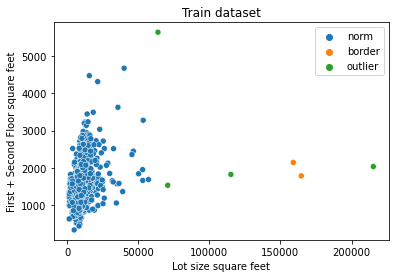

Text(0.5, 1.0, 'Test dataset')

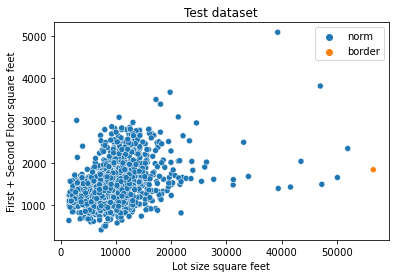

In [48]:
# Train dataset
x1 = np.array(X_train.LotArea)    # Lot size in square feet 
x2 = np.array(X_train['1stFlrSF']) + np.array(X_train['2ndFlrSF']) # First Floor + Second floor square feet 

l = get_DBscan(x1, x2, R='mean')
legend_dict = {1:'norm',2:'border', 3:'outlier'}
new_l = [legend_dict[i] for i in l]

sns.scatterplot(x=x1.reshape(-1), y=x2.reshape(-1),hue = new_l)
plt.xlabel('Lot size square feet')
plt.ylabel('First + Second Floor square feet')
plt.title('Train dataset')
plt.show()

# Test dataset
x1 = np.array(X_test.LotArea)    # Lot size in square feet 
x2 = np.array(X_test['1stFlrSF']) + np.array(X_test['2ndFlrSF']) # First Floor + Second floor square feet 

l = get_DBscan(x1, x2, R='mean')
legend_dict = {1:'norm',2:'border', 3:'outlier'}
new_l = [legend_dict[i] for i in l]

sns.scatterplot(x=x1.reshape(-1), y=x2.reshape(-1),hue = new_l)
plt.xlabel('Lot size square feet')
plt.ylabel('First + Second Floor square feet')
plt.title('Test dataset')

Видно 6 выбросов на Train dataset.  Уберем выбросы

In [49]:
x1 = np.array(X_train.LotArea)    # Lot size in square feet 
x2 = np.array(X_train['1stFlrSF']) + np.array(X_train['2ndFlrSF']) # First Floor + Second floor square feet 

l = get_DBscan(x1, x2, R='mean')

In [50]:
l = np.array(l)
ouliers = np.where(l != 1)[0]+1
df = pd.read_csv('train.csv',index_col='Id')
df.loc[ouliers,['LotArea','1stFlrSF','2ndFlrSF', 'SalePrice'] ]

,LotArea,1stFlrSF,2ndFlrSF,SalePrice
Id,,,,
250,159000,1444,700,277000
314,215245,2036,0,375000
336,164660,1619,167,228950
452,70761,1533,0,280000
707,115149,1824,0,302000
1299,63887,4692,950,160000


In [51]:
X_train.drop(ouliers,inplace=True)
y_train.drop(ouliers,inplace=True)

Если бы мы сортировали только по площади и цене, то вышеуказанные объекты мы бы Не нашли

Text(0, 0.5, 'SalePrice')

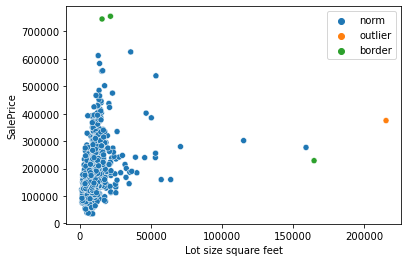

In [52]:
x1 = np.array(df.LotArea)    # Lot size in square feet 
x2 = np.array(df['SalePrice']) # SalePrice

l = get_DBscan(x1, x2, R='mean')
legend_dict = {1:'norm',2:'border', 3:'outlier'}
new_l = [legend_dict[i] for i in l]

sns.scatterplot(x=x1.reshape(-1), y=x2.reshape(-1),hue = new_l)
plt.xlabel('Lot size square feet')
plt.ylabel('SalePrice')

####  генерируем новый признак и строим DBscan на первом и новом признаке

In [53]:
def get_DBscan_with_new_feature(x_1,x_2,R='mean'):    
    '''
        генерируем новый признак и строим DBscan на первом и новом признаке 
    '''
    x1_mean = x_1.mean()
    x2_mean = x_2.mean()

    x_3 = ( (x_1- x1_mean )**2 - (x_2- x2_mean )**2)  # считаем квадрат расстояния от точки до точки А [x1_mean, x2_mean]
    return get_DBscan(x_1,x_3,R=R),get_DBscan(x_2,x_3,R=R)

<AxesSubplot:>

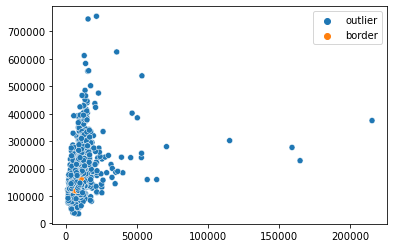

In [54]:
l = get_DBscan_with_new_feature(x1,x2,R=3)[1]
legend_dict = {1:'norm',2:'border', 3:'outlier'}

new_l = [legend_dict[i] for i in l]
sns.scatterplot(x=x1.reshape(-1), y=x2.reshape(-1),hue = new_l)

Результат работы DBscan с генерацией новой оси нам Не подходит 

## ДЗ

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb

#### LightGBM

In [56]:
import lightgbm as lgb

In [57]:
#lgb.Dataset(data=X_train, label=y_train)

In [67]:
lgb_reg = lgb.LGBMRegressor()

In [74]:
def lightGMB_checker(reg_f,X_train_array,y_train_array,X_test_array,y_test_array ):
    lgb_reg.fit(X_train,y_train)
    y_pred_lightGB = lgb_reg.predict(X_test)
    score_lightGB = mean_squared_error(y_test,y_pred_lightGB)
    return round(score_lightGB,2)

In [75]:
lightGMB_checker(lgb_reg, X_train,y_train,  X_test,y_test   )

1656783586.47

#### Optuna - find the best LightGB params:

In [76]:
import optuna

In [93]:
# Оптимизируем результат:

def objective(trial):
        
    booster_kernel = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss','rf'])
    num_leaves = trial.suggest_int('num_leaves', 2, 30,step=1 )
    max_depth = trial.suggest_int('max_depth', -1, 11,step=2 )
    learning_rate = trial.suggest_uniform('learning_rate', 0, 4)
    n_estimators = trial.suggest_int('n_estimators', 10, 100,step=1 )
    
    # objective - решающая функция и ее производная. испольовать встроенный словарь или свою
    
    # Регуляризаторы:
    min_split_gain = trial.suggest_uniform('min_split_gain', 0, .1)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 30,step=1 )
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, .9 ) # L1 регуляризатор
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, .9 ) # L2 регуляризатор
    
    # Bootstrap
    subsample_freq = trial.suggest_int('subsample_freq', 1, 10,step=1 ) # Повторяемость объектов
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0, .9 ) # отбирать признаки у бутстрапных объектов (0 - не отбирать)
    
    
    lgb_reg = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=num_leaves, max_depth= max_depth,
                                learning_rate= learning_rate, n_estimators=n_estimators,n_jobs = -1, 
                                min_split_gain=min_split_gain, min_child_samples=min_child_samples,
                                subsample_freq = 0,colsample_bytree= 1, 
                                reg_alpha=reg_alpha, reg_lambda =reg_lambda  )

    lgb_reg.fit(X_train,y_train)
    y_pred_lightGB = lgb_reg.predict(X_test)
    score_lightGB = mean_squared_error(y_test,y_pred_lightGB)
    
    return score_lightGB

study = optuna.create_study(direction = 'minimize' )
study.optimize(objective, n_trials=1000)

!telegram-send "Job's_Done" 


study.best_params

[I 2021-07-26 11:38:26,811] A new study created in memory with name: no-name-ca447f2f-c75c-4f68-aeb1-a6ba324b3ee4
[I 2021-07-26 11:38:27,997] Trial 0 finished with value: 2525791795.648932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 11, 'learning_rate': 0.5120017413755016, 'n_estimators': 41, 'min_split_gain': 0.06690304615296146, 'min_child_samples': 20, 'reg_alpha': 0.5505108714708585, 'reg_lambda': 0.7511955915221377, 'subsample_freq': 10, 'colsample_bytree': 0.01304232238708034}. Best is trial 0 with value: 2525791795.648932.
[I 2021-07-26 11:38:28,759] Trial 1 finished with value: 7.40715114152418e+65 and parameters: {'boosting_type': 'rf', 'num_leaves': 27, 'max_depth': 3, 'learning_rate': 3.9183638668484075, 'n_estimators': 61, 'min_split_gain': 0.09726186507709904, 'min_child_samples': 24, 'reg_alpha': 0.8033656151387941, 'reg_lambda': 0.5280588422086384, 'subsample_freq': 2, 'colsample_bytree': 0.4597815551946738}. Best is trial 0 with value: 25257

[I 2021-07-26 11:38:42,362] Trial 18 finished with value: 13031102001.744139 and parameters: {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 1.7118200864266346, 'n_estimators': 66, 'min_split_gain': 0.0032370020151535703, 'min_child_samples': 16, 'reg_alpha': 0.3023763250130397, 'reg_lambda': 0.4110078733850435, 'subsample_freq': 9, 'colsample_bytree': 0.8189656326313498}. Best is trial 12 with value: 234372079.23983327.
[I 2021-07-26 11:38:43,503] Trial 19 finished with value: 3303405314.9167533 and parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'max_depth': 9, 'learning_rate': 0.9779351237934174, 'n_estimators': 45, 'min_split_gain': 0.020303926982652043, 'min_child_samples': 14, 'reg_alpha': 0.22702695612943558, 'reg_lambda': 0.2423134675456755, 'subsample_freq': 7, 'colsample_bytree': 0.5858877995894547}. Best is trial 12 with value: 234372079.23983327.
[I 2021-07-26 11:38:44,043] Trial 20 finished with value: 2694426719.7165112 and parameters: {'

[I 2021-07-26 11:38:54,813] Trial 36 finished with value: 3108496957.493323 and parameters: {'boosting_type': 'rf', 'num_leaves': 2, 'max_depth': 11, 'learning_rate': 1.1986665285221585, 'n_estimators': 40, 'min_split_gain': 0.09591707855606382, 'min_child_samples': 23, 'reg_alpha': 0.041889831494882734, 'reg_lambda': 0.5881445792789644, 'subsample_freq': 7, 'colsample_bytree': 0.512311669012976}. Best is trial 12 with value: 234372079.23983327.
[I 2021-07-26 11:38:55,433] Trial 37 finished with value: 2975588739.915888 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.4475260317912364, 'n_estimators': 50, 'min_split_gain': 0.061782711332708934, 'min_child_samples': 26, 'reg_alpha': 0.17706726950445895, 'reg_lambda': 0.36162052649795134, 'subsample_freq': 4, 'colsample_bytree': 0.3659049336358663}. Best is trial 12 with value: 234372079.23983327.
[I 2021-07-26 11:38:56,066] Trial 38 finished with value: 1854188226.327378 and parameters: {'bo

[I 2021-07-26 11:39:05,054] Trial 54 finished with value: 7.967570558064419e+32 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 9, 'learning_rate': 3.9895907665472037, 'n_estimators': 25, 'min_split_gain': 0.04836550876548491, 'min_child_samples': 19, 'reg_alpha': 0.10514189834063983, 'reg_lambda': 0.4326191899809413, 'subsample_freq': 8, 'colsample_bytree': 0.7063898366210597}. Best is trial 41 with value: 229834573.17597044.
[I 2021-07-26 11:39:05,663] Trial 55 finished with value: 223270323.51716703 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 11, 'learning_rate': 0.008215778924758837, 'n_estimators': 28, 'min_split_gain': 0.02717908755793668, 'min_child_samples': 22, 'reg_alpha': 0.27947725994832784, 'reg_lambda': 0.334029418190715, 'subsample_freq': 8, 'colsample_bytree': 0.820714248484178}. Best is trial 55 with value: 223270323.51716703.
[I 2021-07-26 11:39:06,260] Trial 56 finished with value: 2500000018.889967 and parameters:

[I 2021-07-26 11:39:18,942] Trial 72 finished with value: 252213536.89567468 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 11, 'learning_rate': 0.010350316595985178, 'n_estimators': 40, 'min_split_gain': 0.04127405660091824, 'min_child_samples': 20, 'reg_alpha': 0.03721332410013749, 'reg_lambda': 0.43534470099878103, 'subsample_freq': 7, 'colsample_bytree': 0.43347292222240946}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:19,640] Trial 73 finished with value: 3426353588.2371554 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 11, 'learning_rate': 0.3321760591486536, 'n_estimators': 38, 'min_split_gain': 0.05883267575411414, 'min_child_samples': 20, 'reg_alpha': 0.0536917845740041, 'reg_lambda': 0.3901736540749583, 'subsample_freq': 7, 'colsample_bytree': 0.3151807657765625}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:20,509] Trial 74 finished with value: 4194509977.5489326 and parameter

[I 2021-07-26 11:39:31,608] Trial 90 finished with value: 1715768354.2648335 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.20112070717415223, 'n_estimators': 17, 'min_split_gain': 0.04655917487109684, 'min_child_samples': 15, 'reg_alpha': 0.1965427569374425, 'reg_lambda': 0.4176598802442856, 'subsample_freq': 9, 'colsample_bytree': 0.7453152203918341}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:32,146] Trial 91 finished with value: 1043345607.3029355 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'max_depth': 11, 'learning_rate': 0.08819633247666138, 'n_estimators': 33, 'min_split_gain': 0.04953217781075504, 'min_child_samples': 18, 'reg_alpha': 0.12948895639161806, 'reg_lambda': 0.2386717823182891, 'subsample_freq': 7, 'colsample_bytree': 0.6597474987836797}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:32,656] Trial 92 finished with value: 273647630.2850108 and parameters: {'

[I 2021-07-26 11:39:46,644] Trial 108 finished with value: 1.0703063179310766e+17 and parameters: {'boosting_type': 'goss', 'num_leaves': 11, 'max_depth': 9, 'learning_rate': 2.1487436720113218, 'n_estimators': 68, 'min_split_gain': 0.08020813291402916, 'min_child_samples': 10, 'reg_alpha': 0.2495525629278345, 'reg_lambda': 0.44876499523852437, 'subsample_freq': 10, 'colsample_bytree': 0.1140883128873732}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:47,657] Trial 109 finished with value: 2895653289.0945067 and parameters: {'boosting_type': 'goss', 'num_leaves': 12, 'max_depth': 11, 'learning_rate': 0.40455194285125523, 'n_estimators': 56, 'min_split_gain': 0.07397086417545332, 'min_child_samples': 12, 'reg_alpha': 0.2918470799391693, 'reg_lambda': 0.3826260880051892, 'subsample_freq': 9, 'colsample_bytree': 0.02845274276300581}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:39:48,484] Trial 110 finished with value: 2944132845.170737 and para

[I 2021-07-26 11:40:01,313] Trial 126 finished with value: 259138928.3384663 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 11, 'learning_rate': 0.0017799462847486996, 'n_estimators': 15, 'min_split_gain': 0.09988264666793946, 'min_child_samples': 15, 'reg_alpha': 0.7815260643957355, 'reg_lambda': 0.7208488402588793, 'subsample_freq': 3, 'colsample_bytree': 0.8847027821702105}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:02,104] Trial 127 finished with value: 2874204101.62649 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': -1, 'learning_rate': 0.32621957872703167, 'n_estimators': 21, 'min_split_gain': 0.09503470193788877, 'min_child_samples': 16, 'reg_alpha': 0.8615110286759843, 'reg_lambda': 0.6358620896521839, 'subsample_freq': 4, 'colsample_bytree': 0.8610545526389667}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:02,683] Trial 128 finished with value: 240489647.50710216 and parameters

[I 2021-07-26 11:40:12,829] Trial 144 finished with value: 934439043.0119838 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.07726252471851419, 'n_estimators': 20, 'min_split_gain': 0.09986019275985726, 'min_child_samples': 19, 'reg_alpha': 0.8367251228476436, 'reg_lambda': 0.5531798540330665, 'subsample_freq': 4, 'colsample_bytree': 0.7850887687111351}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:13,368] Trial 145 finished with value: 257652260.62263817 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 7, 'learning_rate': 0.0022685226248676388, 'n_estimators': 13, 'min_split_gain': 0.093271422301771, 'min_child_samples': 17, 'reg_alpha': 0.7903730530876548, 'reg_lambda': 0.4977117396942135, 'subsample_freq': 5, 'colsample_bytree': 0.7641838466096644}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:13,949] Trial 146 finished with value: 1652209282.8806612 and parameters: {

[I 2021-07-26 11:40:25,646] Trial 162 finished with value: 227849905.479779 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 9, 'learning_rate': 0.004800133474596154, 'n_estimators': 25, 'min_split_gain': 0.09242083859842848, 'min_child_samples': 18, 'reg_alpha': 0.5990523518577311, 'reg_lambda': 0.5654527232885622, 'subsample_freq': 4, 'colsample_bytree': 0.8200682996202477}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:26,298] Trial 163 finished with value: 267571758.0836031 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 9, 'learning_rate': 0.00045958650352303544, 'n_estimators': 25, 'min_split_gain': 0.02489655033577937, 'min_child_samples': 18, 'reg_alpha': 0.6269121081039789, 'reg_lambda': 0.5588742893032821, 'subsample_freq': 4, 'colsample_bytree': 0.8656934074397035}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:26,880] Trial 164 finished with value: 1117236668.3911207 and parameters:

[I 2021-07-26 11:40:37,555] Trial 180 finished with value: 1556213759.7395594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.2741584088298529, 'n_estimators': 17, 'min_split_gain': 0.0812789653112242, 'min_child_samples': 19, 'reg_alpha': 0.8642866878471764, 'reg_lambda': 0.5019947702239095, 'subsample_freq': 2, 'colsample_bytree': 0.899661318956039}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:38,294] Trial 181 finished with value: 229907504.3078255 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.0058454219013750995, 'n_estimators': 19, 'min_split_gain': 0.0975428995489796, 'min_child_samples': 16, 'reg_alpha': 0.3858412413310089, 'reg_lambda': 0.5764322677467707, 'subsample_freq': 4, 'colsample_bytree': 0.8366667366828907}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:38,866] Trial 182 finished with value: 491230745.7285356 and parameters: {'bo

[I 2021-07-26 11:40:49,142] Trial 198 finished with value: 693188980.5503265 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 11, 'learning_rate': 0.06878644367438098, 'n_estimators': 24, 'min_split_gain': 0.09387553303724026, 'min_child_samples': 16, 'reg_alpha': 0.5833958843973586, 'reg_lambda': 0.59313983675862, 'subsample_freq': 4, 'colsample_bytree': 0.7974431406826582}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:49,800] Trial 199 finished with value: 1732204693.8877568 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 11, 'learning_rate': 0.22938239948750708, 'n_estimators': 19, 'min_split_gain': 0.09996007208563717, 'min_child_samples': 15, 'reg_alpha': 0.5245055829682973, 'reg_lambda': 0.6128573599484098, 'subsample_freq': 4, 'colsample_bytree': 0.8279531190386238}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:40:50,350] Trial 200 finished with value: 244888193.768469 and parameters: {

[I 2021-07-26 11:41:00,658] Trial 216 finished with value: 246357150.0410711 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'max_depth': 11, 'learning_rate': 0.0023030322350432956, 'n_estimators': 26, 'min_split_gain': 0.09288131878807769, 'min_child_samples': 18, 'reg_alpha': 0.6136309398039442, 'reg_lambda': 0.6007954101804338, 'subsample_freq': 5, 'colsample_bytree': 0.7315638479636368}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:41:01,280] Trial 217 finished with value: 1597113490.2010896 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.14794504021213328, 'n_estimators': 26, 'min_split_gain': 0.0909542780146411, 'min_child_samples': 17, 'reg_alpha': 0.6917201858921528, 'reg_lambda': 0.5799287637649821, 'subsample_freq': 5, 'colsample_bytree': 0.7578699576544277}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:41:01,928] Trial 218 finished with value: 1185915610.0260868 and parameters

[I 2021-07-26 11:41:14,172] Trial 234 finished with value: 2004261794.680067 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.06843726045489891, 'n_estimators': 75, 'min_split_gain': 0.08990377761100261, 'min_child_samples': 16, 'reg_alpha': 0.6187337147955158, 'reg_lambda': 0.5880720549537636, 'subsample_freq': 5, 'colsample_bytree': 0.8369888281029899}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:41:15,088] Trial 235 finished with value: 2584353120.7547045 and parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'max_depth': 11, 'learning_rate': 0.14196027363862274, 'n_estimators': 69, 'min_split_gain': 0.0923552711077763, 'min_child_samples': 15, 'reg_alpha': 0.6303938042870326, 'reg_lambda': 0.4979899601300953, 'subsample_freq': 5, 'colsample_bytree': 0.8613390305799282}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:41:16,085] Trial 236 finished with value: 255887090.40553364 and parameters: 

[I 2021-07-26 11:41:32,091] Trial 252 finished with value: 2085480995.6828444 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.20061700036404334, 'n_estimators': 99, 'min_split_gain': 0.08772985092815262, 'min_child_samples': 17, 'reg_alpha': 0.36418234515843984, 'reg_lambda': 0.609373460916334, 'subsample_freq': 6, 'colsample_bytree': 0.853679626455287}. Best is trial 64 with value: 222671684.25207987.
[I 2021-07-26 11:41:33,183] Trial 253 finished with value: 222623017.59308434 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 11, 'learning_rate': 0.0023309851817703217, 'n_estimators': 88, 'min_split_gain': 0.09083869385999879, 'min_child_samples': 15, 'reg_alpha': 0.31053254980698697, 'reg_lambda': 0.5594795120186851, 'subsample_freq': 5, 'colsample_bytree': 0.0036381552428580155}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:41:34,279] Trial 254 finished with value: 222772738.81063494 and para

[I 2021-07-26 11:41:50,177] Trial 270 finished with value: 2725718995.619806 and parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'max_depth': 11, 'learning_rate': 0.15644768364669792, 'n_estimators': 90, 'min_split_gain': 0.008262412772331251, 'min_child_samples': 14, 'reg_alpha': 0.2835371305521532, 'reg_lambda': 0.8546705667382377, 'subsample_freq': 5, 'colsample_bytree': 0.3494362005555785}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:41:51,056] Trial 271 finished with value: 269143917.142863 and parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'max_depth': 11, 'learning_rate': 0.00013084524760247724, 'n_estimators': 87, 'min_split_gain': 0.08736543580754928, 'min_child_samples': 15, 'reg_alpha': 0.3004124037618344, 'reg_lambda': 0.47694416636143444, 'subsample_freq': 5, 'colsample_bytree': 0.36262162099487993}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:41:52,020] Trial 272 finished with value: 227020477.2387354 and parame

[I 2021-07-26 11:42:07,515] Trial 288 finished with value: 2233500500.3528686 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 5, 'learning_rate': 0.1518959323703545, 'n_estimators': 89, 'min_split_gain': 0.00913293253272001, 'min_child_samples': 14, 'reg_alpha': 0.2987162355104208, 'reg_lambda': 0.7733779517948833, 'subsample_freq': 5, 'colsample_bytree': 0.4155053903528421}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:08,471] Trial 289 finished with value: 2341116162.639508 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.2702386207537803, 'n_estimators': 86, 'min_split_gain': 0.006153699665844226, 'min_child_samples': 13, 'reg_alpha': 0.30923773162729223, 'reg_lambda': 0.7065871861550215, 'subsample_freq': 5, 'colsample_bytree': 0.3197078450928537}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:09,353] Trial 290 finished with value: 1725323335.8631592 and parameters

[I 2021-07-26 11:42:24,655] Trial 306 finished with value: 2453825592.1022816 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.1303038383853807, 'n_estimators': 78, 'min_split_gain': 0.01020593332690244, 'min_child_samples': 15, 'reg_alpha': 0.3274797809178714, 'reg_lambda': 0.5015613067424214, 'subsample_freq': 7, 'colsample_bytree': 0.40119506024200524}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:25,714] Trial 307 finished with value: 240689256.17085484 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.0009030742284517233, 'n_estimators': 80, 'min_split_gain': 0.011472690989541776, 'min_child_samples': 15, 'reg_alpha': 0.3123573243837345, 'reg_lambda': 0.5322812599243915, 'subsample_freq': 2, 'colsample_bytree': 0.41752069671463987}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:26,579] Trial 308 finished with value: 2315725224.6256504 and parame

[I 2021-07-26 11:42:42,032] Trial 324 finished with value: 4.607530885784426e+76 and parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'max_depth': 7, 'learning_rate': 3.7471569276074335, 'n_estimators': 82, 'min_split_gain': 0.004267512637190704, 'min_child_samples': 14, 'reg_alpha': 0.3084437335977118, 'reg_lambda': 0.4602829176485346, 'subsample_freq': 6, 'colsample_bytree': 0.5385477217593776}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:43,175] Trial 325 finished with value: 2531163882.9976068 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 5, 'learning_rate': 0.2783342948591862, 'n_estimators': 88, 'min_split_gain': 0.007390716135306088, 'min_child_samples': 15, 'reg_alpha': 0.3418949865987281, 'reg_lambda': 0.5206991153207978, 'subsample_freq': 5, 'colsample_bytree': 0.4375151237476524}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:42:43,916] Trial 326 finished with value: 2257229512.206631 and paramete

[I 2021-07-26 11:43:00,379] Trial 342 finished with value: 271078324.3122351 and parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'max_depth': 5, 'learning_rate': 7.606081712663651e-05, 'n_estimators': 81, 'min_split_gain': 0.07340336939373508, 'min_child_samples': 21, 'reg_alpha': 0.2996465093782067, 'reg_lambda': 0.8232684007207528, 'subsample_freq': 5, 'colsample_bytree': 0.37121934509045545}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:01,354] Trial 343 finished with value: 2592614913.3323684 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.0904770064231953, 'n_estimators': 89, 'min_split_gain': 0.008054879241347703, 'min_child_samples': 13, 'reg_alpha': 0.23620352244462728, 'reg_lambda': 0.6079022129626438, 'subsample_freq': 5, 'colsample_bytree': 0.39881305286454943}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:02,199] Trial 344 finished with value: 2365697439.710347 and paramet

[I 2021-07-26 11:43:17,944] Trial 360 finished with value: 6044327229.805735 and parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 1.7907138040975903, 'n_estimators': 91, 'min_split_gain': 0.07941240529291224, 'min_child_samples': 16, 'reg_alpha': 0.14169834375966162, 'reg_lambda': 0.5226576193695082, 'subsample_freq': 6, 'colsample_bytree': 0.3070469217392346}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:18,942] Trial 361 finished with value: 228165469.09689754 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 11, 'learning_rate': 0.0015356601766101973, 'n_estimators': 78, 'min_split_gain': 0.006857419206886917, 'min_child_samples': 24, 'reg_alpha': 0.3630925832766565, 'reg_lambda': 0.49435697258397904, 'subsample_freq': 5, 'colsample_bytree': 0.867002235740435}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:20,010] Trial 362 finished with value: 1886296092.0741012 and parame

[I 2021-07-26 11:43:37,081] Trial 378 finished with value: 2940971519.9502206 and parameters: {'boosting_type': 'rf', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.19204495355540643, 'n_estimators': 94, 'min_split_gain': 0.0019683861775369313, 'min_child_samples': 12, 'reg_alpha': 0.24670013108471026, 'reg_lambda': 0.46800520103624543, 'subsample_freq': 9, 'colsample_bytree': 0.020161873000058582}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:38,341] Trial 379 finished with value: 2125580120.6146493 and parameters: {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.07049546214758289, 'n_estimators': 92, 'min_split_gain': 0.0008640234817056159, 'min_child_samples': 7, 'reg_alpha': 0.2632140971764182, 'reg_lambda': 0.4721066406665778, 'subsample_freq': 2, 'colsample_bytree': 0.0422233471299677}. Best is trial 253 with value: 222623017.59308434.
[I 2021-07-26 11:43:39,657] Trial 380 finished with value: 2464929434.2095666 and paramet

[I 2021-07-26 11:44:06,670] Trial 396 finished with value: 2186336763.1810465 and parameters: {'boosting_type': 'rf', 'num_leaves': 7, 'max_depth': 7, 'learning_rate': 0.07530640225566022, 'n_estimators': 83, 'min_split_gain': 0.0010391404170474053, 'min_child_samples': 11, 'reg_alpha': 0.2132274936402483, 'reg_lambda': 0.5113637801812024, 'subsample_freq': 4, 'colsample_bytree': 0.012156029061235155}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:44:10,009] Trial 397 finished with value: 225304005.33679095 and parameters: {'boosting_type': 'rf', 'num_leaves': 11, 'max_depth': 5, 'learning_rate': 0.0022533089751440995, 'n_estimators': 89, 'min_split_gain': 0.00028686299799548175, 'min_child_samples': 12, 'reg_alpha': 0.3086231468264097, 'reg_lambda': 0.42765431650431585, 'subsample_freq': 3, 'colsample_bytree': 0.44430682010540024}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:44:15,379] Trial 398 finished with value: 1949628837.1629267 and pa

[I 2021-07-26 11:45:07,015] Trial 414 finished with value: 1394352493.508076 and parameters: {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.07288002461524133, 'n_estimators': 63, 'min_split_gain': 0.06345896208764713, 'min_child_samples': 27, 'reg_alpha': 0.3149475806527254, 'reg_lambda': 0.5257205075546191, 'subsample_freq': 4, 'colsample_bytree': 0.04914836067643601}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:45:12,012] Trial 415 finished with value: 2998921394.9497933 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.20387192601284165, 'n_estimators': 86, 'min_split_gain': 0.06806091051402034, 'min_child_samples': 14, 'reg_alpha': 0.35213779273034385, 'reg_lambda': 0.5606210625913363, 'subsample_freq': 5, 'colsample_bytree': 0.4336281496952684}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:45:18,357] Trial 416 finished with value: 2199955027.7857304 and parameters:

[I 2021-07-26 11:46:29,980] Trial 432 finished with value: 2241252632.573565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 7, 'learning_rate': 0.06695848414054623, 'n_estimators': 81, 'min_split_gain': 0.09686954388754093, 'min_child_samples': 13, 'reg_alpha': 0.7645457323972359, 'reg_lambda': 0.5998623781196298, 'subsample_freq': 8, 'colsample_bytree': 0.04150716217959164}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:46:33,383] Trial 433 finished with value: 253760666.7967444 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.004721463862945894, 'n_estimators': 88, 'min_split_gain': 0.09457193388445649, 'min_child_samples': 28, 'reg_alpha': 0.31306038713239914, 'reg_lambda': 0.6272571401813786, 'subsample_freq': 8, 'colsample_bytree': 0.30011402860023056}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:46:37,241] Trial 434 finished with value: 4614420498.838593 and parameter

[I 2021-07-26 11:47:51,820] Trial 450 finished with value: 1323292107.481932 and parameters: {'boosting_type': 'rf', 'num_leaves': 7, 'max_depth': 5, 'learning_rate': 0.15142438289056318, 'n_estimators': 17, 'min_split_gain': 0.015545635253877633, 'min_child_samples': 14, 'reg_alpha': 0.2778381669233059, 'reg_lambda': 0.5912886997454991, 'subsample_freq': 6, 'colsample_bytree': 0.4150022784115525}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:47:57,496] Trial 451 finished with value: 2075807251.1204786 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 11, 'learning_rate': 0.06775245698475818, 'n_estimators': 89, 'min_split_gain': 0.09347499250460024, 'min_child_samples': 10, 'reg_alpha': 0.8196006261716388, 'reg_lambda': 0.5071795080545958, 'subsample_freq': 5, 'colsample_bytree': 0.8211416824502256}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:48:03,775] Trial 452 finished with value: 258486391.96387696 and parameters:

[I 2021-07-26 11:49:15,487] Trial 468 finished with value: 536099325.02432305 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.08101341456193274, 'n_estimators': 14, 'min_split_gain': 0.02912214829790117, 'min_child_samples': 13, 'reg_alpha': 0.8175894859802313, 'reg_lambda': 0.6258949049238017, 'subsample_freq': 5, 'colsample_bytree': 0.4011987005188254}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:49:18,294] Trial 469 finished with value: 2038158985.688081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.07852276010396292, 'n_estimators': 93, 'min_split_gain': 0.017289669929062952, 'min_child_samples': 15, 'reg_alpha': 0.8837313333571479, 'reg_lambda': 0.6807199994587408, 'subsample_freq': 5, 'colsample_bytree': 0.4342295159359622}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:49:20,325] Trial 470 finished with value: 259728601.72562167 and parameters

[I 2021-07-26 11:50:42,219] Trial 486 finished with value: 2218386204.9027348 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 9, 'learning_rate': 0.12313404817165419, 'n_estimators': 68, 'min_split_gain': 0.024833155979172374, 'min_child_samples': 15, 'reg_alpha': 0.27216788792586166, 'reg_lambda': 0.3976344866545396, 'subsample_freq': 7, 'colsample_bytree': 0.35220312069825455}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:50:47,064] Trial 487 finished with value: 224164353.9919866 and parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 9, 'learning_rate': 0.003486532367907625, 'n_estimators': 67, 'min_split_gain': 0.021075879981412523, 'min_child_samples': 16, 'reg_alpha': 0.8992887926437307, 'reg_lambda': 0.5273466836705905, 'subsample_freq': 5, 'colsample_bytree': 0.33537910561878614}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:50:53,045] Trial 488 finished with value: 2151088260.592161 and para

[I 2021-07-26 11:51:23,144] Trial 504 finished with value: 1555696794.6587956 and parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'max_depth': 11, 'learning_rate': 0.14350374337506755, 'n_estimators': 66, 'min_split_gain': 0.01832670586314344, 'min_child_samples': 10, 'reg_alpha': 0.32394533050940133, 'reg_lambda': 0.4939298920270871, 'subsample_freq': 5, 'colsample_bytree': 0.3712045883358786}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:51:24,308] Trial 505 finished with value: 256175456.71448508 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 11, 'learning_rate': 0.0058228960214272716, 'n_estimators': 94, 'min_split_gain': 0.022951285524666097, 'min_child_samples': 21, 'reg_alpha': 0.3037794125080254, 'reg_lambda': 0.4589175114760026, 'subsample_freq': 5, 'colsample_bytree': 0.40073595795658074}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:51:25,381] Trial 506 finished with value: 1711011588.9285014 and par

[I 2021-07-26 11:51:43,609] Trial 522 finished with value: 2613283247.612816 and parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.13758911648025973, 'n_estimators': 97, 'min_split_gain': 0.021195019687681154, 'min_child_samples': 15, 'reg_alpha': 0.2742300563598178, 'reg_lambda': 0.5747919647514322, 'subsample_freq': 5, 'colsample_bytree': 0.4349856940918203}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:51:44,625] Trial 523 finished with value: 253617850.6150227 and parameters: {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.000545878528654508, 'n_estimators': 69, 'min_split_gain': 0.004965899225361782, 'min_child_samples': 14, 'reg_alpha': 0.2974475740971896, 'reg_lambda': 0.47091894295768644, 'subsample_freq': 1, 'colsample_bytree': 0.09861374903442023}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:51:45,294] Trial 524 finished with value: 4517662265.43048 and parameters:

[I 2021-07-26 11:52:03,226] Trial 540 finished with value: 240421925.19467294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 3, 'learning_rate': 0.00404168664532705, 'n_estimators': 87, 'min_split_gain': 0.09477329106332903, 'min_child_samples': 9, 'reg_alpha': 0.32664082503640857, 'reg_lambda': 0.5974985294735241, 'subsample_freq': 5, 'colsample_bytree': 0.5676124754811926}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:04,547] Trial 541 finished with value: 227310322.78283742 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.001477665008225602, 'n_estimators': 83, 'min_split_gain': 0.09768629672187643, 'min_child_samples': 10, 'reg_alpha': 0.3434584086071244, 'reg_lambda': 0.56613105842227, 'subsample_freq': 6, 'colsample_bytree': 0.3625779694386819}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:05,559] Trial 542 finished with value: 2086636112.0254166 and parameters:

[I 2021-07-26 11:52:23,345] Trial 558 finished with value: 7.237088239386046e+23 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 9, 'learning_rate': 2.255074659959844, 'n_estimators': 74, 'min_split_gain': 0.09315016497643135, 'min_child_samples': 13, 'reg_alpha': 0.3477426040271314, 'reg_lambda': 0.02825229312790245, 'subsample_freq': 6, 'colsample_bytree': 0.39807584553469527}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:24,473] Trial 559 finished with value: 235323514.6721782 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 5, 'learning_rate': 0.0009639155713281986, 'n_estimators': 92, 'min_split_gain': 0.09613470531861021, 'min_child_samples': 25, 'reg_alpha': 0.242915821631517, 'reg_lambda': 0.6732420608621239, 'subsample_freq': 7, 'colsample_bytree': 0.019114328966346253}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:25,582] Trial 560 finished with value: 2777728416.8835616 and para

[I 2021-07-26 11:52:44,459] Trial 576 finished with value: 223809045.783963 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'max_depth': 7, 'learning_rate': 0.004659444664886544, 'n_estimators': 78, 'min_split_gain': 0.0062489754981203275, 'min_child_samples': 14, 'reg_alpha': 0.8633814025639752, 'reg_lambda': 0.6817729010997238, 'subsample_freq': 8, 'colsample_bytree': 0.32943668866079096}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:45,210] Trial 577 finished with value: 265324997.20852396 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.0004308435559143269, 'n_estimators': 39, 'min_split_gain': 0.0038582932057900222, 'min_child_samples': 22, 'reg_alpha': 0.8389363953748683, 'reg_lambda': 0.4063373072033712, 'subsample_freq': 8, 'colsample_bytree': 0.4188754378310135}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:52:46,041] Trial 578 finished with value: 803338856.0681894 and param

[I 2021-07-26 11:53:02,244] Trial 594 finished with value: 773297770.3252709 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 7, 'learning_rate': 0.07214670160317058, 'n_estimators': 21, 'min_split_gain': 0.02083665383159503, 'min_child_samples': 13, 'reg_alpha': 0.3030044677382611, 'reg_lambda': 0.5331615642076887, 'subsample_freq': 5, 'colsample_bytree': 0.36833081152770036}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:03,368] Trial 595 finished with value: 2488551315.62231 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.22008743885986792, 'n_estimators': 79, 'min_split_gain': 0.010982519468993127, 'min_child_samples': 15, 'reg_alpha': 0.8566490971918237, 'reg_lambda': 0.4819949007427027, 'subsample_freq': 10, 'colsample_bytree': 0.32041003036184307}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:04,580] Trial 596 finished with value: 2302755401.232924 and parameters

[I 2021-07-26 11:53:22,228] Trial 612 finished with value: 2592589707.8759794 and parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.22917660660815412, 'n_estimators': 66, 'min_split_gain': 0.00017316041909581372, 'min_child_samples': 21, 'reg_alpha': 0.27815773499058327, 'reg_lambda': 0.4454512982610657, 'subsample_freq': 4, 'colsample_bytree': 0.06189070580145057}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:22,892] Trial 613 finished with value: 250756412.35407126 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'max_depth': 5, 'learning_rate': 0.003888493517474857, 'n_estimators': 91, 'min_split_gain': 0.09808714540518013, 'min_child_samples': 14, 'reg_alpha': 0.11501674458281486, 'reg_lambda': 0.747836695387867, 'subsample_freq': 5, 'colsample_bytree': 0.3507793440207001}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:23,981] Trial 614 finished with value: 1829907413.3195703 and para

[I 2021-07-26 11:53:41,674] Trial 630 finished with value: 256319444.16776615 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.0020105122064174624, 'n_estimators': 16, 'min_split_gain': 0.09248144116739337, 'min_child_samples': 15, 'reg_alpha': 0.816915735720305, 'reg_lambda': 0.6730647562497559, 'subsample_freq': 5, 'colsample_bytree': 0.46805649099575847}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:42,804] Trial 631 finished with value: 222204454.9741182 and parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'max_depth': 11, 'learning_rate': 0.0025924197729853475, 'n_estimators': 76, 'min_split_gain': 0.04615797580779927, 'min_child_samples': 20, 'reg_alpha': 0.2553403034819848, 'reg_lambda': 0.8947940273935365, 'subsample_freq': 4, 'colsample_bytree': 0.0458507401821924}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:53:43,843] Trial 632 finished with value: 242446772.24199712 and parame

[I 2021-07-26 11:54:01,019] Trial 648 finished with value: 1672826765.414946 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 9, 'learning_rate': 0.08091263530043827, 'n_estimators': 75, 'min_split_gain': 0.024288347268454552, 'min_child_samples': 20, 'reg_alpha': 0.8165176947855389, 'reg_lambda': 0.6848602279750672, 'subsample_freq': 3, 'colsample_bytree': 0.05139621270896091}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:01,899] Trial 649 finished with value: 4391976445.593677 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.31904706000219746, 'n_estimators': 69, 'min_split_gain': 0.02844486780321879, 'min_child_samples': 19, 'reg_alpha': 0.8469155031556203, 'reg_lambda': 0.8013969028440957, 'subsample_freq': 4, 'colsample_bytree': 0.005621694645924508}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:02,901] Trial 650 finished with value: 1623455054.0998926 and paramet

[I 2021-07-26 11:54:19,662] Trial 666 finished with value: 255613332.33735684 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 11, 'learning_rate': 0.005704682679200369, 'n_estimators': 71, 'min_split_gain': 0.09778039357793636, 'min_child_samples': 14, 'reg_alpha': 0.803927038225096, 'reg_lambda': 0.6557850491282384, 'subsample_freq': 4, 'colsample_bytree': 0.03094235330732388}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:20,452] Trial 667 finished with value: 228127216.7868125 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 11, 'learning_rate': 0.003967023573094985, 'n_estimators': 30, 'min_split_gain': 0.09263859111875629, 'min_child_samples': 13, 'reg_alpha': 0.8388937691622154, 'reg_lambda': 0.6014369306811987, 'subsample_freq': 4, 'colsample_bytree': 0.06353267482256547}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:21,573] Trial 668 finished with value: 231803411.1969249 and parame

[I 2021-07-26 11:54:38,017] Trial 684 finished with value: 222841558.81781086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.005137626097455247, 'n_estimators': 35, 'min_split_gain': 0.09464742366596504, 'min_child_samples': 15, 'reg_alpha': 0.2830761071955351, 'reg_lambda': 0.5875829041442746, 'subsample_freq': 8, 'colsample_bytree': 0.45525506001263194}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:38,761] Trial 685 finished with value: 2470985825.1748796 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'max_depth': 11, 'learning_rate': 0.19878930309210338, 'n_estimators': 34, 'min_split_gain': 0.09512720848194611, 'min_child_samples': 15, 'reg_alpha': 0.8321826430790861, 'reg_lambda': 0.6134887993758809, 'subsample_freq': 8, 'colsample_bytree': 0.484934409633953}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:39,524] Trial 686 finished with value: 1098393691.3106081 and paramete

[I 2021-07-26 11:54:54,524] Trial 702 finished with value: 1786189197.4894428 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.12505696230076546, 'n_estimators': 41, 'min_split_gain': 0.09726018003769747, 'min_child_samples': 28, 'reg_alpha': 0.2551799077556317, 'reg_lambda': 0.4385077614262484, 'subsample_freq': 7, 'colsample_bytree': 0.5283513607164778}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:55,354] Trial 703 finished with value: 1191960307.2639601 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 9, 'learning_rate': 0.05783968242179586, 'n_estimators': 51, 'min_split_gain': 0.09747119330471524, 'min_child_samples': 29, 'reg_alpha': 0.22543186921422634, 'reg_lambda': 0.5695134462351931, 'subsample_freq': 6, 'colsample_bytree': 0.5158184671879323}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:54:56,340] Trial 704 finished with value: 233701040.4136887 and parameters

[I 2021-07-26 11:55:12,172] Trial 720 finished with value: 223512106.53088832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 9, 'learning_rate': 0.002010822921072746, 'n_estimators': 79, 'min_split_gain': 0.09934662629532232, 'min_child_samples': 16, 'reg_alpha': 0.8034494720510668, 'reg_lambda': 0.6684440031556553, 'subsample_freq': 6, 'colsample_bytree': 0.06079801080178543}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:55:13,135] Trial 721 finished with value: 2116475336.685215 and parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.24152032638186138, 'n_estimators': 73, 'min_split_gain': 0.08956520815698865, 'min_child_samples': 14, 'reg_alpha': 0.28557494736127986, 'reg_lambda': 0.7729077122456709, 'subsample_freq': 4, 'colsample_bytree': 0.0179380196769669}. Best is trial 386 with value: 222194371.53262553.
[I 2021-07-26 11:55:14,211] Trial 722 finished with value: 2394133329.6140633 and paramete

[I 2021-07-26 11:55:30,425] Trial 738 finished with value: 216663650.46707675 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.0063762447735894335, 'n_estimators': 83, 'min_split_gain': 0.08784369421986589, 'min_child_samples': 15, 'reg_alpha': 0.25615427055881634, 'reg_lambda': 0.8793909166130525, 'subsample_freq': 3, 'colsample_bytree': 0.4369881475418078}. Best is trial 738 with value: 216663650.46707675.
[I 2021-07-26 11:55:31,354] Trial 739 finished with value: 221381050.2630873 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.006746067024733306, 'n_estimators': 83, 'min_split_gain': 0.08363742298275939, 'min_child_samples': 16, 'reg_alpha': 0.23237183019287588, 'reg_lambda': 0.851883204099417, 'subsample_freq': 3, 'colsample_bytree': 0.4496010916091084}. Best is trial 738 with value: 216663650.46707675.
[I 2021-07-26 11:55:32,445] Trial 740 finished with value: 1712180771.4307132 and paramet

[I 2021-07-26 11:55:47,163] Trial 756 finished with value: 1912056696.11002 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.07348843126825756, 'n_estimators': 86, 'min_split_gain': 0.08341717807059594, 'min_child_samples': 15, 'reg_alpha': 0.24677462400993255, 'reg_lambda': 0.8822067612899192, 'subsample_freq': 3, 'colsample_bytree': 0.4093409793991276}. Best is trial 738 with value: 216663650.46707675.
[I 2021-07-26 11:55:48,152] Trial 757 finished with value: 6056471849.55807 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 1.7180040249195543, 'n_estimators': 81, 'min_split_gain': 0.08958311353035148, 'min_child_samples': 15, 'reg_alpha': 0.19195751499151406, 'reg_lambda': 0.8646695627144159, 'subsample_freq': 3, 'colsample_bytree': 0.43153169048657175}. Best is trial 738 with value: 216663650.46707675.
[I 2021-07-26 11:55:48,930] Trial 758 finished with value: 1379591194.950292 and parameters: {

[I 2021-07-26 11:56:02,617] Trial 774 finished with value: 246922452.6930201 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.0008459229922440853, 'n_estimators': 83, 'min_split_gain': 0.07803908830198024, 'min_child_samples': 17, 'reg_alpha': 0.26376531669282754, 'reg_lambda': 0.7887259530552002, 'subsample_freq': 3, 'colsample_bytree': 0.5269395234620408}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:03,599] Trial 775 finished with value: 236266882.16801155 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.0021202360022647753, 'n_estimators': 80, 'min_split_gain': 0.08082522992098992, 'min_child_samples': 17, 'reg_alpha': 0.19479224836690898, 'reg_lambda': 0.8128104107912963, 'subsample_freq': 3, 'colsample_bytree': 0.4391826751917039}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:04,352] Trial 776 finished with value: 2413370509.114515 and parame

[I 2021-07-26 11:56:18,489] Trial 792 finished with value: 222659543.00966117 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.005217185548810295, 'n_estimators': 81, 'min_split_gain': 0.0799165086565552, 'min_child_samples': 16, 'reg_alpha': 0.1365097626077509, 'reg_lambda': 0.8406789407441774, 'subsample_freq': 3, 'colsample_bytree': 0.5110550834769559}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:19,570] Trial 793 finished with value: 1396769303.2549298 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.0704345325305032, 'n_estimators': 79, 'min_split_gain': 0.07990455060987793, 'min_child_samples': 16, 'reg_alpha': 0.17761829551202984, 'reg_lambda': 0.8201703958495529, 'subsample_freq': 3, 'colsample_bytree': 0.5063582016051332}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:20,477] Trial 794 finished with value: 228854341.15233752 and parameters

[I 2021-07-26 11:56:35,663] Trial 810 finished with value: 223862906.61579198 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.004016076317999677, 'n_estimators': 77, 'min_split_gain': 0.08487345090499379, 'min_child_samples': 17, 'reg_alpha': 0.21619239473583765, 'reg_lambda': 0.8545273660677116, 'subsample_freq': 3, 'colsample_bytree': 0.4979009752663795}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:36,670] Trial 811 finished with value: 2416335704.5844803 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.17940647310920838, 'n_estimators': 82, 'min_split_gain': 0.08173161821846892, 'min_child_samples': 16, 'reg_alpha': 0.08211981387159754, 'reg_lambda': 0.8738599511335221, 'subsample_freq': 3, 'colsample_bytree': 0.4254238886451824}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:37,727] Trial 812 finished with value: 1901042158.742369 and paramete

[I 2021-07-26 11:56:53,567] Trial 828 finished with value: 257188651.48006266 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.00043658061176204965, 'n_estimators': 77, 'min_split_gain': 0.08529711841495857, 'min_child_samples': 27, 'reg_alpha': 0.25242517747495136, 'reg_lambda': 0.8995067756043219, 'subsample_freq': 3, 'colsample_bytree': 0.43155868945103626}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:55,074] Trial 829 finished with value: 232631972.4125555 and parameters: {'boosting_type': 'goss', 'num_leaves': 18, 'max_depth': 9, 'learning_rate': 0.0019894928396312415, 'n_estimators': 86, 'min_split_gain': 0.08845683822587364, 'min_child_samples': 18, 'reg_alpha': 0.27982140510810777, 'reg_lambda': 0.8429725987306433, 'subsample_freq': 2, 'colsample_bytree': 0.3989557394235616}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:56:56,060] Trial 830 finished with value: 1979472695.7225318 and pa

[I 2021-07-26 11:57:11,206] Trial 846 finished with value: 1759359519.4313886 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.07766063327775403, 'n_estimators': 81, 'min_split_gain': 0.08519503427146481, 'min_child_samples': 16, 'reg_alpha': 0.11217836779317863, 'reg_lambda': 0.6872929674594176, 'subsample_freq': 1, 'colsample_bytree': 0.5078413383786926}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:57:12,334] Trial 847 finished with value: 3823661880.5818815 and parameters: {'boosting_type': 'goss', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.19480066286134134, 'n_estimators': 87, 'min_split_gain': 0.0769039238959543, 'min_child_samples': 15, 'reg_alpha': 0.22235558144747136, 'reg_lambda': 0.8976895785958748, 'subsample_freq': 3, 'colsample_bytree': 0.3956135855470825}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:57:13,390] Trial 848 finished with value: 271197705.96320826 and parameter

[I 2021-07-26 11:57:29,979] Trial 864 finished with value: 4133945587.3110924 and parameters: {'boosting_type': 'goss', 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.3805755976891432, 'n_estimators': 86, 'min_split_gain': 0.07871333130475056, 'min_child_samples': 19, 'reg_alpha': 0.3273921532678957, 'reg_lambda': 0.8985978179156277, 'subsample_freq': 3, 'colsample_bytree': 0.5344108333628221}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:57:31,187] Trial 865 finished with value: 1845380891.3434455 and parameters: {'boosting_type': 'goss', 'num_leaves': 10, 'max_depth': 9, 'learning_rate': 0.13254952345993826, 'n_estimators': 79, 'min_split_gain': 0.08619845127842123, 'min_child_samples': 16, 'reg_alpha': 0.29877384237896204, 'reg_lambda': 0.7862160356097188, 'subsample_freq': 3, 'colsample_bytree': 0.4342028169384505}. Best is trial 765 with value: 207099404.67167068.
[I 2021-07-26 11:57:32,100] Trial 866 finished with value: 225089329.44810054 and parameter

[I 2021-07-26 11:57:46,713] Trial 882 finished with value: 206787227.62942323 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.0067328985240077315, 'n_estimators': 78, 'min_split_gain': 0.0050128886012880255, 'min_child_samples': 17, 'reg_alpha': 0.17105062371723442, 'reg_lambda': 0.8331161782266956, 'subsample_freq': 2, 'colsample_bytree': 0.5121426823906705}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:57:47,596] Trial 883 finished with value: 267673184.1970699 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.00018767985714210345, 'n_estimators': 78, 'min_split_gain': 0.08661887711766574, 'min_child_samples': 18, 'reg_alpha': 0.1478195497186525, 'reg_lambda': 0.8326482846867538, 'subsample_freq': 2, 'colsample_bytree': 0.5185598316630571}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:57:48,439] Trial 884 finished with value: 243691896.16839194 and par

[I 2021-07-26 11:58:01,955] Trial 900 finished with value: 3610399022.0415697 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.26779229805875193, 'n_estimators': 98, 'min_split_gain': 0.08240586494194183, 'min_child_samples': 16, 'reg_alpha': 0.17813042870457302, 'reg_lambda': 0.8856556561679363, 'subsample_freq': 2, 'colsample_bytree': 0.4958887393944207}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:02,974] Trial 901 finished with value: 237279448.81776372 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.0015887687670002142, 'n_estimators': 97, 'min_split_gain': 0.0875601527600456, 'min_child_samples': 17, 'reg_alpha': 0.2019030587475914, 'reg_lambda': 0.8395028556278709, 'subsample_freq': 2, 'colsample_bytree': 0.5186537432959961}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:03,763] Trial 902 finished with value: 247842406.77243868 and paramete

[I 2021-07-26 11:58:17,872] Trial 918 finished with value: 1996138225.8577034 and parameters: {'boosting_type': 'goss', 'num_leaves': 5, 'max_depth': 9, 'learning_rate': 0.06830626752690266, 'n_estimators': 98, 'min_split_gain': 0.006897863877960608, 'min_child_samples': 17, 'reg_alpha': 0.21346384734371926, 'reg_lambda': 0.8555885821062903, 'subsample_freq': 2, 'colsample_bytree': 0.5124848039652273}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:18,636] Trial 919 finished with value: 234869594.14299813 and parameters: {'boosting_type': 'goss', 'num_leaves': 3, 'max_depth': 9, 'learning_rate': 0.0037670864340428227, 'n_estimators': 78, 'min_split_gain': 0.08682329628194757, 'min_child_samples': 18, 'reg_alpha': 0.17460456662631205, 'reg_lambda': 0.8204721123292283, 'subsample_freq': 2, 'colsample_bytree': 0.5650087669010634}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:19,456] Trial 920 finished with value: 2287605968.925165 and parame

[I 2021-07-26 11:58:34,281] Trial 936 finished with value: 2349960797.6690807 and parameters: {'boosting_type': 'goss', 'num_leaves': 24, 'max_depth': 9, 'learning_rate': 0.07952216003933109, 'n_estimators': 80, 'min_split_gain': 0.08396334878021239, 'min_child_samples': 17, 'reg_alpha': 0.22905029265370982, 'reg_lambda': 0.8352819505973385, 'subsample_freq': 2, 'colsample_bytree': 0.4664938935566526}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:35,105] Trial 937 finished with value: 2222531824.727342 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 9, 'learning_rate': 0.28130959840046316, 'n_estimators': 84, 'min_split_gain': 0.00432062703552738, 'min_child_samples': 16, 'reg_alpha': 0.1373616693001767, 'reg_lambda': 0.5213786996020076, 'subsample_freq': 3, 'colsample_bytree': 0.01714763181358867}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:35,939] Trial 938 finished with value: 3200508382.164389 and parameter

[I 2021-07-26 11:58:50,057] Trial 954 finished with value: 2069915517.2853317 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.16415292785557387, 'n_estimators': 78, 'min_split_gain': 0.09307644572453913, 'min_child_samples': 15, 'reg_alpha': 0.2362146662824862, 'reg_lambda': 0.8477152920578828, 'subsample_freq': 4, 'colsample_bytree': 0.47734577848009174}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:51,070] Trial 955 finished with value: 225145625.0539932 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 7, 'learning_rate': 0.0028066519827677893, 'n_estimators': 83, 'min_split_gain': 0.0902110933343484, 'min_child_samples': 16, 'reg_alpha': 0.17567592935047568, 'reg_lambda': 0.7827821142001683, 'subsample_freq': 3, 'colsample_bytree': 0.06100174499408355}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:58:51,989] Trial 956 finished with value: 6618369763.234863 and paramete

[I 2021-07-26 11:59:08,125] Trial 972 finished with value: 1828538559.2902677 and parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 7, 'learning_rate': 0.0688961483917251, 'n_estimators': 100, 'min_split_gain': 0.011408454709444165, 'min_child_samples': 26, 'reg_alpha': 0.14060179423953512, 'reg_lambda': 0.513314430020382, 'subsample_freq': 2, 'colsample_bytree': 0.43139839739077734}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:59:08,904] Trial 973 finished with value: 245394928.5367696 and parameters: {'boosting_type': 'rf', 'num_leaves': 3, 'max_depth': 9, 'learning_rate': 0.001278317662061977, 'n_estimators': 73, 'min_split_gain': 0.08409636498238311, 'min_child_samples': 15, 'reg_alpha': 0.18715262970336358, 'reg_lambda': 0.8992999782256447, 'subsample_freq': 4, 'colsample_bytree': 0.4801423973228929}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:59:10,133] Trial 974 finished with value: 257408381.33514765 and parameter

[I 2021-07-26 11:59:25,984] Trial 990 finished with value: 2222255079.322067 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 9, 'learning_rate': 0.14694402996376382, 'n_estimators': 77, 'min_split_gain': 0.005489549673830714, 'min_child_samples': 16, 'reg_alpha': 0.8409629479631918, 'reg_lambda': 0.8522571997878922, 'subsample_freq': 3, 'colsample_bytree': 0.4770490276396879}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:59:26,997] Trial 991 finished with value: 2168416928.555501 and parameters: {'boosting_type': 'goss', 'num_leaves': 6, 'max_depth': 9, 'learning_rate': 0.26213779696360023, 'n_estimators': 82, 'min_split_gain': 0.08852279848800043, 'min_child_samples': 15, 'reg_alpha': 0.15594437538769454, 'reg_lambda': 0.6714288234377797, 'subsample_freq': 4, 'colsample_bytree': 0.49727590739879474}. Best is trial 882 with value: 206787227.62942323.
[I 2021-07-26 11:59:27,860] Trial 992 finished with value: 258403217.1288604 and parameters

{'boosting_type': 'goss',
 'num_leaves': 4,
 'max_depth': 9,
 'learning_rate': 0.0067328985240077315,
 'n_estimators': 78,
 'min_split_gain': 0.0050128886012880255,
 'min_child_samples': 17,
 'reg_alpha': 0.17105062371723442,
 'reg_lambda': 0.8331161782266956,
 'subsample_freq': 2,
 'colsample_bytree': 0.5121426823906705}

In [95]:
# Заполняем данные из best trial (882)
score_lightGB = 206787227.62
lightGB_best_params = study.best_params
lightGB_best_params['boosting_type'] = 'gbdt'
lightGB_best_params

{'boosting_type': 'gbdt',
 'num_leaves': 4,
 'max_depth': 9,
 'learning_rate': 0.0067328985240077315,
 'n_estimators': 78,
 'min_split_gain': 0.0050128886012880255,
 'min_child_samples': 17,
 'reg_alpha': 0.17105062371723442,
 'reg_lambda': 0.8331161782266956,
 'subsample_freq': 2,
 'colsample_bytree': 0.5121426823906705}

#### Теперь проведем K-fold на самом лучшем LightGB регрессоре:

In [117]:
train_dataset = lgb.Dataset( data=X_train, label=list(y_train), feature_name=X_train.columns)

In [101]:
# Оказывается для lgb.LGBMRegressor и для lgb.cv нужв разные словари params - ака параметры запуска
# Создаем словарь для запуска lgb.cv # https://lightgbm.readthedocs.io/en/latest/Parameters.html

lightGB_best_params_for_CV= dict()
lightGB_best_params_for_CV['boosting'] = lightGB_best_params['boosting_type']
lightGB_best_params_for_CV['num_iterations'] = lightGB_best_params['n_estimators']
lightGB_best_params_for_CV['num_leaves'] = lightGB_best_params['num_leaves']
lightGB_best_params_for_CV['max_depth'] = lightGB_best_params['max_depth']
lightGB_best_params_for_CV['learning_rate'] = lightGB_best_params['learning_rate']
lightGB_best_params_for_CV['min_gain_to_split'] = lightGB_best_params['min_split_gain']
lightGB_best_params_for_CV['min_data_in_leaf'] = lightGB_best_params['min_child_samples']
lightGB_best_params_for_CV['lambda_l1'] = lightGB_best_params['reg_alpha']
lightGB_best_params_for_CV['lambda_l2'] = lightGB_best_params['reg_lambda']
lightGB_best_params_for_CV['bagging_freq'] = lightGB_best_params['subsample_freq']
lightGB_best_params_for_CV['feature_fraction '] = lightGB_best_params['colsample_bytree']
lightGB_best_params_for_CV

{'boosting': 'gbdt',
 'num_iterations': 78,
 'num_leaves': 4,
 'max_depth': 9,
 'learning_rate': 0.0067328985240077315,
 'min_gain_to_split': 0.0050128886012880255,
 'min_data_in_leaf': 17,
 'lambda_l1': 0.17105062371723442,
 'lambda_l2': 0.8331161782266956,
 'bagging_freq': 2,
 'feature_fraction ': 0.5121426823906705}

In [118]:
# Стартуем k-fold для LightGB Regressor
lgb.cv(params=lightGB_best_params_for_CV, train_set=train_dataset, num_boost_round = 100,folds =None,
      nfold =5, stratified =True,shuffle  =True, metrics = 'mean_squared_error',
       early_stopping_rounds=10, eval_train_metric = True,
       return_cvbooster = True, feature_name=list(X_train.columns))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 294
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 294
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 294
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Unknown parameter: 0.5121426823906705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_row_wise=true` to remove the overhead

{'train l2-mean': [6232343074.14626,
  6184580448.177034,
  6137425114.941589,
  6090886300.994983,
  6044952443.718084,
  5999620377.799901,
  5954683423.726311,
  5909974850.249981,
  5866073004.155205,
  5822655360.549042,
  5779844862.193439,
  5737004400.016502,
  5695041968.311151,
  5653041602.09272,
  5611500241.500647,
  5570821858.453934,
  5530074167.280354,
  5490306338.760256,
  5450419463.369783,
  5411271124.483609,
  5372592499.382326,
  5334233311.558723,
  5296460729.746512,
  5258316412.894135,
  5221424067.318082,
  5184211577.490896,
  5147320087.253683,
  5111785479.777569,
  5074950160.769178,
  5039629582.245186,
  5004582201.790003,
  4969285228.765341,
  4935212367.39176,
  4900441720.709408,
  4866882138.031375,
  4833583746.091815,
  4799767332.37132,
  4767207980.477875,
  4734331047.353719,
  4702413550.69093,
  4670146522.877019,
  4638210092.837042,
  4606769984.569963,
  4575934242.914912,
  4544853482.513859,
  4514419627.056727,
  4483804655.323504,
 

In [121]:
# подхватываем результаты
cv_booster = _

In [124]:
# Проверим что есть в результатах
cv_booster.keys()

dict_keys(['train l2-mean', 'train l2-stdv', 'valid l2-mean', 'valid l2-stdv', 'cvbooster'])

Text(0.5, 1.0, 'LightGB CV results')

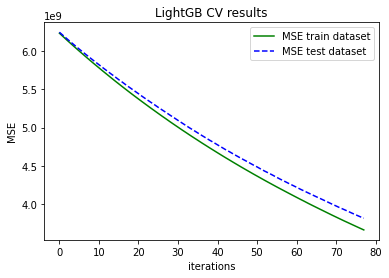

In [131]:
# Посмторим как обучалась модель lightGB regressor
plt.plot(cv_booster['train l2-mean'],'g-' , label='MSE train dataset' )
plt.plot(cv_booster['valid l2-mean'],'b--' , label='MSE test dataset' )
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.legend()
plt.title('LightGB CV results')

In [138]:
# Найдем самыю лучший регрессор уже на тестовой выборке:
y_pred_lgb = cv_booster['cvbooster'].predict(X_test)
for i in y_pred_lgb:
    print(mean_squared_error(y_test,i  ))

237088652.75570455
208814391.33496064
209003542.30786887
201377359.7479559
212177816.87778583


In [144]:
# Самый лучший light GB регрессор:
lgb_best_reg = cv_booster['cvbooster'].boosters[3]
score_lightGB = 201377359.74

### ДЗ.№3 Random Forest
Построить случайный лес, вывести важность признаков

In [60]:
# Random Forest "из коробки"
rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, n_jobs=-1 )
rf_reg.fit(X_train,y_train)
y_pred_random_forest = rf_reg.predict(X_test)
score_random_forest = mean_squared_error(y_test,y_pred_random_forest)
score_random_forest , score_random_forest**.5

(1388006206.3343275, 37255.955313672035)

In [145]:
# Optuna (all RandomForest params in one trial): 

def objective(trial):
        
    
    max_leaf_nodes  = trial.suggest_int('max_leaf_nodes', 2, 30,step=1 )
    max_depth = trial.suggest_int('max_depth', 3, 500,step=1 )
    n_estimators = trial.suggest_int('n_estimators', 10, 100,step=1 )

    
    # Регуляризаторы:
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0, .1)
    ccp_alpha  = trial.suggest_uniform('ccp_alpha', 0, .9 ) # L1 регуляризатор
    
    
    # Bootstrap
    max_features  = trial.suggest_uniform('max_features', 0, .9 ) # отбирать признаки у бутстрапных объектов (0 - не отбирать)
    max_samples = trial.suggest_uniform('max_features', 0, 1 ) # объем бутстрапной выборки (в %)
    
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, criterion='mse', max_depth=max_depth, n_jobs=-1,
                                  min_impurity_decrease=min_impurity_decrease,bootstrap=True,max_leaf_nodes =max_leaf_nodes ,
                                  max_features =max_features , ccp_alpha =ccp_alpha ,max_samples = max_samples )

    rf_reg.fit(X_train,y_train)
    y_pred_rf = rf_reg.predict(X_test)
    score_rf = mean_squared_error(y_test,y_pred_lightGB)
    
    return score_rf

study = optuna.create_study(direction = 'minimize' )
study.optimize(objective, n_trials=1000)

!telegram-send "Job's_Done" 

study.best_params

[I 2021-07-26 15:06:58,668] A new study created in memory with name: no-name-a2a53851-6304-45be-98ea-4501bc3ba9cf
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:06:58,797] Trial 0 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 97, 'n_estimators': 25, 'min_impurity_decrease': 0.047769056437743575, 'ccp_alpha': 0.7304706410123158, 'max_features': 0.07695148946590993}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:02,047] Trial 11 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 19, 'max_depth': 122, 'n_estimators': 15, 'min_impurity_decrease': 0.03234364464183366, 'ccp_alpha': 0.43775587208314276, 'max_features': 0.35371659153565027}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:07:05,514] Trial 21 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 319, 'n_estimators': 42, 'min_impurity_decrease': 0.0425828233770284, 'ccp_alpha': 0.18398648420383246, 'max_features': 0.8891426622531404}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:05,644] Trial 22 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 23, 'max_depth': 3, 'n_estimators': 35, 'min_impurity_decrease': 0.05725068619270619, 'ccp_alpha': 0.2

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:07,578] Trial 32 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 130, 'n_estimators': 10, 'min_impurity_decrease': 0.06687714163448201, 'ccp_alpha': 0.11820709816509045, 'max_features': 0.6663284115305146}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:09,784] Trial 43 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 21, 'max_depth': 337, 'n_estimators': 19, 'min_impurity_decrease': 0.037600079842035145, 'ccp_alpha': 0.48681357183336105, 'max_features': 0.6015690561759892}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:07:11,849] Trial 53 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 127, 'n_estimators': 10, 'min_impurity_decrease': 0.07568554942924838, 'ccp_alpha': 0.3271713111720125, 'max_features': 0.8054946861978194}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:12,251] Trial 54 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 104, 'n_estimators': 31, 'min_impurity_decrease': 0.025263216866389167, 'ccp_alpha': 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:14,558] Trial 64 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 498, 'n_estimators': 37, 'min_impurity_decrease': 0.041158166700677984, 'ccp_alpha': 0.2201366382406749, 'max_features': 0.31012107620471296}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:07:16,604] Trial 74 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 88, 'n_estimators': 26, 'min_impurity_decrease': 0.0756437293319582, 'ccp_alpha': 0.6697475885444736, 'max_features': 0.685083706277878}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:16,774] Trial 75 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 144, 'n_estimators': 10, 'min_impurity_decrease': 0.06770839486354464, 'ccp_alpha': 0.61

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:19,900] Trial 85 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 217, 'n_estimators': 59, 'min_impurity_decrease': 0.07977189955424943, 'ccp_alpha': 0.765140531239771, 'max_features': 0.7829867975349198}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:07:22,010] Trial 95 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 243, 'n_estimators': 76, 'min_impurity_decrease': 0.0027289148767649218, 'ccp_alpha': 0.15906251908707528, 'max_features': 0.006387879873289398}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:22,310] Trial 96 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 324, 'n_estimators': 100, 'min_impurity_decrease': 0.048987211512773084, 'ccp_alp

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:24,552] Trial 106 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 23, 'max_depth': 155, 'n_estimators': 24, 'min_impurity_decrease': 0.0664540646375711, 'ccp_alpha': 0.7184565028711944, 'max_features': 0.7706693665913382}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows t

[I 2021-07-26 15:07:27,330] Trial 116 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 126, 'n_estimators': 56, 'min_impurity_decrease': 0.023315116777561602, 'ccp_alpha': 0.8251549283766227, 'max_features': 0.886741290161585}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:27,730] Trial 117 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 95, 'n_estimators': 64, 'min_impurity_decrease': 0.07678512939047674, 'ccp_alpha': 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:31,160] Trial 127 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 494, 'n_estimators': 68, 'min_impurity_decrease': 0.0882876371644911, 'ccp_alpha': 0.8932630943324668, 'max_features': 0.20914425505231188}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:07:33,611] Trial 137 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 481, 'n_estimators': 86, 'min_impurity_decrease': 0.04981999608170823, 'ccp_alpha': 0.43680136488120314, 'max_features': 0.18089813695473625}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:33,911] Trial 138 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 393, 'n_estimators': 89, 'min_impurity_decrease': 0.0561651243432572, 'ccp_alpha'

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:36,391] Trial 148 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 396, 'n_estimators': 98, 'min_impurity_decrease': 0.07283660544773612, 'ccp_alpha': 0.3503155959754512, 'max_features': 0.08808017781258}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:07:38,743] Trial 158 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 89, 'n_estimators': 25, 'min_impurity_decrease': 0.01896598049130304, 'ccp_alpha': 0.6645025742096313, 'max_features': 0.5959287435253386}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:39,087] Trial 159 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 105, 'n_estimators': 30, 'min_impurity_decrease': 0.012660137431661523, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:42,886] Trial 169 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 68, 'n_estimators': 61, 'min_impurity_decrease': 0.0172257045407766, 'ccp_alpha': 0.5854463351511616, 'max_features': 0.4435798977946245}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:07:46,415] Trial 179 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 56, 'n_estimators': 54, 'min_impurity_decrease': 0.09018061381648158, 'ccp_alpha': 0.8998528264892324, 'max_features': 0.3603085373713487}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:46,585] Trial 180 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 13, 'n_estimators': 50, 'min_impurity_decrease': 0.0824331520232747, 'ccp_alpha': 0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:49,045] Trial 190 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 478, 'n_estimators': 81, 'min_impurity_decrease': 0.09644584060836249, 'ccp_alpha': 0.12430314552820124, 'max_features': 0.216484813741468}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:07:51,756] Trial 200 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 413, 'n_estimators': 89, 'min_impurity_decrease': 0.05202370175560679, 'ccp_alpha': 0.4313677976559117, 'max_features': 0.01933003495491479}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:51,996] Trial 201 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 6, 'max_depth': 436, 'n_estimators': 93, 'min_impurity_decrease': 0.05832417198973213, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:55,291] Trial 211 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 18, 'max_depth': 421, 'n_estimators': 95, 'min_impurity_decrease': 0.06593091214654677, 'ccp_alpha': 0.34478887262335967, 'max_features': 0.7468040114961598}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:07:58,269] Trial 221 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 114, 'n_estimators': 27, 'min_impurity_decrease': 0.011775855367878124, 'ccp_alpha': 0.6706256776858075, 'max_features': 0.7044643934785016}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:07:58,601] Trial 222 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 160, 'n_estimators': 24, 'min_impurity_decrease': 0.044319273754336266, 'ccp_alpha

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:01,199] Trial 232 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 100, 'n_estimators': 64, 'min_impurity_decrease': 0.016239633735832336, 'ccp_alpha': 0.5868685535123355, 'max_features': 0.5931282978264545}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:08:05,183] Trial 242 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 34, 'n_estimators': 59, 'min_impurity_decrease': 0.02382372788796159, 'ccp_alpha': 0.7377068532207053, 'max_features': 0.4376825040400073}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:05,603] Trial 243 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 28, 'max_depth': 51, 'n_estimators': 68, 'min_impurity_decrease': 0.027035633908897225, 'ccp_alpha': 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:09,422] Trial 253 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 7, 'n_estimators': 60, 'min_impurity_decrease': 0.022781973268364356, 'ccp_alpha': 0.7788705463917224, 'max_features': 0.4068328278113181}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows t

[I 2021-07-26 15:08:12,307] Trial 263 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 270, 'n_estimators': 83, 'min_impurity_decrease': 0.09114263124803632, 'ccp_alpha': 0.8699577777047462, 'max_features': 0.458217293755441}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:12,537] Trial 264 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 9, 'max_depth': 500, 'n_estimators': 80, 'min_impurity_decrease': 0.09427674616284469, 'ccp_alpha': 0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:15,268] Trial 274 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 486, 'n_estimators': 88, 'min_impurity_decrease': 0.08806340060842353, 'ccp_alpha': 0.2617628762896301, 'max_features': 0.06576296886261725}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:08:18,078] Trial 284 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 363, 'n_estimators': 94, 'min_impurity_decrease': 0.051464472938420484, 'ccp_alpha': 0.4552685994163914, 'max_features': 0.23171332116343918}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:18,378] Trial 285 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 360, 'n_estimators': 91, 'min_impurity_decrease': 0.049939310460018975, 'ccp_alph

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:21,218] Trial 295 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 209, 'n_estimators': 88, 'min_impurity_decrease': 0.05913748498264195, 'ccp_alpha': 0.19814523708357681, 'max_features': 0.2550217918550143}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:08:24,431] Trial 305 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 445, 'n_estimators': 93, 'min_impurity_decrease': 0.04434434527091227, 'ccp_alpha': 0.4210987951041042, 'max_features': 0.2775113800492824}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:24,701] Trial 306 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 14, 'max_depth': 377, 'n_estimators': 96, 'min_impurity_decrease': 0.043135820294848665, 'ccp_alpha'

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:28,734] Trial 316 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 16, 'max_depth': 179, 'n_estimators': 14, 'min_impurity_decrease': 0.064508621280751, 'ccp_alpha': 0.6165880334166806, 'max_features': 0.7040965249235426}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:08:31,726] Trial 326 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 109, 'n_estimators': 24, 'min_impurity_decrease': 0.0017108498891028195, 'ccp_alpha': 0.6377544919852326, 'max_features': 0.8448605478047334}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:32,000] Trial 327 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 21, 'max_depth': 184, 'n_estimators': 22, 'min_impurity_decrease': 0.009059012988575428, 'ccp_alph

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:34,566] Trial 337 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 98, 'n_estimators': 27, 'min_impurity_decrease': 0.010506454432756862, 'ccp_alpha': 0.5997414637809252, 'max_features': 0.8367967318231637}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:08:37,707] Trial 347 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 102, 'n_estimators': 72, 'min_impurity_decrease': 0.020890731084133154, 'ccp_alpha': 0.7212303875329424, 'max_features': 0.8649870152643006}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:38,197] Trial 348 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 92, 'n_estimators': 70, 'min_impurity_decrease': 0.030159847752763348, 'ccp_alpha'

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:42,507] Trial 358 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 70, 'n_estimators': 66, 'min_impurity_decrease': 0.0141569118209998, 'ccp_alpha': 0.7285303503789089, 'max_features': 0.4928222309196265}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:08:46,181] Trial 368 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 30, 'max_depth': 28, 'n_estimators': 64, 'min_impurity_decrease': 0.01981872234084145, 'ccp_alpha': 0.832366441162731, 'max_features': 0.3929525773998924}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:46,502] Trial 369 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 57, 'n_estimators': 57, 'min_impurity_decrease': 0.02464951240672798, 'ccp_alpha': 0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:50,376] Trial 379 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 7, 'max_depth': 49, 'n_estimators': 51, 'min_impurity_decrease': 0.08345923198062422, 'ccp_alpha': 0.8280821172238249, 'max_features': 0.4469181217843602}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:08:53,470] Trial 389 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 4, 'n_estimators': 80, 'min_impurity_decrease': 0.09371396749566688, 'ccp_alpha': 0.8275956767116255, 'max_features': 0.4191257992413583}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:53,720] Trial 390 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 263, 'n_estimators': 82, 'min_impurity_decrease': 0.09066277280199087, 'ccp_alpha': 0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:56,301] Trial 400 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 291, 'n_estimators': 75, 'min_impurity_decrease': 0.0999263786191425, 'ccp_alpha': 0.09470663303033372, 'max_features': 0.1802828268494346}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:08:58,831] Trial 410 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 7, 'max_depth': 261, 'n_estimators': 82, 'min_impurity_decrease': 0.09767257476073286, 'ccp_alpha': 0.26077471785687967, 'max_features': 0.10955350328346009}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:08:59,091] Trial 411 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 6, 'max_depth': 327, 'n_estimators': 87, 'min_impurity_decrease': 0.09541853677768504, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:01,912] Trial 421 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 351, 'n_estimators': 88, 'min_impurity_decrease': 0.09512684777560751, 'ccp_alpha': 0.2528871805729134, 'max_features': 0.2901339852878979}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:09:04,803] Trial 431 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 4, 'max_depth': 363, 'n_estimators': 91, 'min_impurity_decrease': 0.04959083337006954, 'ccp_alpha': 0.3444402132012725, 'max_features': 0.25419804209144115}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:05,103] Trial 432 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 439, 'n_estimators': 88, 'min_impurity_decrease': 0.05552521668481595, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:08,335] Trial 442 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 14, 'max_depth': 431, 'n_estimators': 95, 'min_impurity_decrease': 0.054174724070617235, 'ccp_alpha': 0.3713788562817274, 'max_features': 0.2262485022664856}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:09:11,395] Trial 452 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 403, 'n_estimators': 100, 'min_impurity_decrease': 0.04881978300258069, 'ccp_alpha': 0.4792364436281345, 'max_features': 0.0418140676745538}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:11,656] Trial 453 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 3, 'max_depth': 419, 'n_estimators': 98, 'min_impurity_decrease': 0.04655694574603828, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:15,045] Trial 463 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 18, 'max_depth': 409, 'n_estimators': 98, 'min_impurity_decrease': 0.06783386741480847, 'ccp_alpha': 0.4988123373924047, 'max_features': 0.6606594705653095}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:19,141] Trial 474 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 214, 'n_estimators': 35, 'min_impurity_decrease': 0.06506798834561933, 'ccp_alpha': 0.5154196805352736, 'max_features': 0.7703076334932918}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:09:22,073] Trial 484 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 21, 'max_depth': 169, 'n_estimators': 27, 'min_impurity_decrease': 0.0005722431737394031, 'ccp_alpha': 0.6206260604917521, 'max_features': 0.7906046089105099}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:22,375] Trial 485 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 20, 'max_depth': 171, 'n_estimators': 24, 'min_impurity_decrease': 0.005341570971185438, 'ccp_alph

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:25,057] Trial 495 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 184, 'n_estimators': 27, 'min_impurity_decrease': 0.008774275453002588, 'ccp_alpha': 0.6001220474712127, 'max_features': 0.8459987838783233}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:09:27,903] Trial 505 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 123, 'n_estimators': 19, 'min_impurity_decrease': 0.01611502487017721, 'ccp_alpha': 0.6819810921432908, 'max_features': 0.6443667242227624}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:28,173] Trial 506 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 88, 'n_estimators': 29, 'min_impurity_decrease': 0.042460055309958694, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:30,571] Trial 516 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 99, 'n_estimators': 64, 'min_impurity_decrease': 0.02883657821183295, 'ccp_alpha': 0.7035460860735478, 'max_features': 0.5740373603526697}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows t

[I 2021-07-26 15:09:35,510] Trial 526 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 76, 'n_estimators': 70, 'min_impurity_decrease': 0.035101738890548545, 'ccp_alpha': 0.7632270277130895, 'max_features': 0.5505473002405117}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:35,982] Trial 527 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 100, 'n_estimators': 66, 'min_impurity_decrease': 0.03095117831341732, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:40,450] Trial 537 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 68, 'n_estimators': 58, 'min_impurity_decrease': 0.03060214612992303, 'ccp_alpha': 0.749254961947328, 'max_features': 0.4877525841855541}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:09:44,030] Trial 547 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 38, 'n_estimators': 61, 'min_impurity_decrease': 0.029595504551455702, 'ccp_alpha': 0.8135471372990889, 'max_features': 0.4223073425879134}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:44,360] Trial 548 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 24, 'n_estimators': 62, 'min_impurity_decrease': 0.031734131797971424, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:48,163] Trial 558 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 28, 'max_depth': 27, 'n_estimators': 55, 'min_impurity_decrease': 0.023527928740180594, 'ccp_alpha': 0.8470442831594276, 'max_features': 0.38232362209044846}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:09:51,836] Trial 568 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 7, 'max_depth': 17, 'n_estimators': 79, 'min_impurity_decrease': 0.0895261269005538, 'ccp_alpha': 0.8860166913429558, 'max_features': 0.37182229664645944}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:52,087] Trial 569 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 3, 'n_estimators': 51, 'min_impurity_decrease': 0.08257253759136336, 'ccp_alpha': 0.83

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:54,669] Trial 579 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 9, 'max_depth': 274, 'n_estimators': 80, 'min_impurity_decrease': 0.092741238741818, 'ccp_alpha': 0.06878212003831291, 'max_features': 0.3930383419619172}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:09:57,579] Trial 589 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 267, 'n_estimators': 79, 'min_impurity_decrease': 0.08731758340691846, 'ccp_alpha': 0.08604995979600796, 'max_features': 0.17180431120925138}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:09:57,829] Trial 590 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 285, 'n_estimators': 76, 'min_impurity_decrease': 0.0968994317920431, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:00,419] Trial 600 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 5, 'max_depth': 300, 'n_estimators': 85, 'min_impurity_decrease': 0.09995004522425788, 'ccp_alpha': 0.12220439987453713, 'max_features': 0.1258206832421853}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:10:02,949] Trial 610 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 11, 'max_depth': 322, 'n_estimators': 85, 'min_impurity_decrease': 0.08572872892912715, 'ccp_alpha': 0.2366977234734029, 'max_features': 0.0994905582074021}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:03,219] Trial 611 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 11, 'max_depth': 331, 'n_estimators': 87, 'min_impurity_decrease': 0.09785203585160074, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:06,050] Trial 621 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 325, 'n_estimators': 89, 'min_impurity_decrease': 0.046884595459392615, 'ccp_alpha': 0.2842241902907065, 'max_features': 0.13799054551707174}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allow

[I 2021-07-26 15:10:09,000] Trial 631 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 3, 'max_depth': 308, 'n_estimators': 91, 'min_impurity_decrease': 0.052307749875125174, 'ccp_alpha': 0.3145624638886463, 'max_features': 0.2978504204075513}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:09,300] Trial 632 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 4, 'max_depth': 364, 'n_estimators': 91, 'min_impurity_decrease': 0.04894130340886566, 'ccp_alpha': 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:12,320] Trial 642 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 4, 'max_depth': 438, 'n_estimators': 95, 'min_impurity_decrease': 0.05708445416302796, 'ccp_alpha': 0.361030898367122, 'max_features': 0.2862646340676842}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:10:15,742] Trial 652 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 429, 'n_estimators': 97, 'min_impurity_decrease': 0.05870856631684599, 'ccp_alpha': 0.3862614288189291, 'max_features': 0.2760504380610401}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:16,093] Trial 653 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 414, 'n_estimators': 99, 'min_impurity_decrease': 0.056275589506897504, 'ccp_alpha'

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:19,324] Trial 663 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 401, 'n_estimators': 100, 'min_impurity_decrease': 0.04477139082079527, 'ccp_alpha': 0.4605880101528625, 'max_features': 0.03534682352329675}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allow

[I 2021-07-26 15:10:22,085] Trial 673 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 403, 'n_estimators': 100, 'min_impurity_decrease': 0.06191438696767376, 'ccp_alpha': 0.4003865530834872, 'max_features': 0.0016592511619733588}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:22,355] Trial 674 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 3, 'max_depth': 387, 'n_estimators': 97, 'min_impurity_decrease': 0.06254287897092513, 'ccp_alph

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:24,885] Trial 684 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 18, 'max_depth': 404, 'n_estimators': 14, 'min_impurity_decrease': 0.06360097643756388, 'ccp_alpha': 0.4054379684030944, 'max_features': 0.00361629823014694}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:10:27,245] Trial 694 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 15, 'max_depth': 394, 'n_estimators': 12, 'min_impurity_decrease': 0.06599110938612238, 'ccp_alpha': 0.5085541743685926, 'max_features': 0.7371592491480301}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:27,437] Trial 695 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 17, 'max_depth': 382, 'n_estimators': 11, 'min_impurity_decrease': 0.06818754922202834, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:30,369] Trial 705 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 20, 'max_depth': 211, 'n_estimators': 27, 'min_impurity_decrease': 0.07132980126361667, 'ccp_alpha': 0.5287074778908157, 'max_features': 0.7719906407039728}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:10:33,481] Trial 715 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 20, 'max_depth': 166, 'n_estimators': 29, 'min_impurity_decrease': 0.004877019865083833, 'ccp_alpha': 0.5927384662404042, 'max_features': 0.7905775403168486}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:33,765] Trial 716 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 21, 'max_depth': 160, 'n_estimators': 23, 'min_impurity_decrease': 0.003504152395249246, 'ccp_alpha

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:36,795] Trial 726 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 187, 'n_estimators': 24, 'min_impurity_decrease': 0.010601975798777072, 'ccp_alpha': 0.5787582786174186, 'max_features': 0.8198084964641745}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:10:39,765] Trial 736 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 23, 'max_depth': 138, 'n_estimators': 18, 'min_impurity_decrease': 0.012647786202026223, 'ccp_alpha': 0.6708465298202837, 'max_features': 0.8509353065498907}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:40,030] Trial 737 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 22, 'max_depth': 138, 'n_estimators': 20, 'min_impurity_decrease': 0.012476459171190103, 'ccp_alpha

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:42,637] Trial 747 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 111, 'n_estimators': 22, 'min_impurity_decrease': 0.011607972597118276, 'ccp_alpha': 0.707286846645443, 'max_features': 0.6114815979833492}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:10:45,071] Trial 757 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 25, 'max_depth': 103, 'n_estimators': 30, 'min_impurity_decrease': 0.01740995733543268, 'ccp_alpha': 0.7313011923757394, 'max_features': 0.5923577238613872}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:45,271] Trial 758 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 24, 'max_depth': 110, 'n_estimators': 18, 'min_impurity_decrease': 0.019202693063934486, 'ccp_alpha'

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:49,603] Trial 768 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 26, 'max_depth': 83, 'n_estimators': 70, 'min_impurity_decrease': 0.017263875541235586, 'ccp_alpha': 0.7515815058208666, 'max_features': 0.5536770514800406}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:10:54,586] Trial 778 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 72, 'n_estimators': 70, 'min_impurity_decrease': 0.03279588331235945, 'ccp_alpha': 0.7476727984884438, 'max_features': 0.5325314188929887}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:55,036] Trial 779 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 76, 'n_estimators': 63, 'min_impurity_decrease': 0.029103578370011176, 'ccp_alpha': 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:10:59,470] Trial 789 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 27, 'max_depth': 82, 'n_estimators': 60, 'min_impurity_decrease': 0.03303613726086253, 'ccp_alpha': 0.7647008408423254, 'max_features': 0.535469214101342}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to

[I 2021-07-26 15:11:03,535] Trial 799 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 28, 'max_depth': 52, 'n_estimators': 57, 'min_impurity_decrease': 0.026651077755181257, 'ccp_alpha': 0.80310856928409, 'max_features': 0.45150199701119215}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:03,895] Trial 800 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 29, 'max_depth': 55, 'n_estimators': 60, 'min_impurity_decrease': 0.02708846270666822, 'ccp_alpha': 0

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:07,899] Trial 810 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 30, 'max_depth': 41, 'n_estimators': 56, 'min_impurity_decrease': 0.025554959259034442, 'ccp_alpha': 0.837055853247769, 'max_features': 0.41171121658133125}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:11:11,854] Trial 820 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 30, 'max_depth': 13, 'n_estimators': 76, 'min_impurity_decrease': 0.02136545637215931, 'ccp_alpha': 0.8487855395339319, 'max_features': 0.388395950735259}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:12,304] Trial 821 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 30, 'max_depth': 24, 'n_estimators': 76, 'min_impurity_decrease': 0.024372708416847647, 'ccp_alpha': 0

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:16,324] Trial 831 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 30, 'max_depth': 12, 'n_estimators': 78, 'min_impurity_decrease': 0.08330886325882297, 'ccp_alpha': 0.8734002469096942, 'max_features': 0.35970715194847097}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:11:18,955] Trial 841 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 7, 'max_depth': 11, 'n_estimators': 50, 'min_impurity_decrease': 0.08947738984254187, 'ccp_alpha': 0.8984189820774092, 'max_features': 0.3429449633432359}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:19,205] Trial 842 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 8, 'max_depth': 5, 'n_estimators': 52, 'min_impurity_decrease': 0.08707861827338724, 'ccp_alpha': 0.87

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:21,815] Trial 852 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 9, 'max_depth': 255, 'n_estimators': 80, 'min_impurity_decrease': 0.0917278987597793, 'ccp_alpha': 0.042273215749233525, 'max_features': 0.34455926175438883}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:11:24,956] Trial 862 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 9, 'max_depth': 264, 'n_estimators': 80, 'min_impurity_decrease': 0.09007640515307604, 'ccp_alpha': 0.07879204789891542, 'max_features': 0.16544879965427198}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:25,186] Trial 863 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 9, 'max_depth': 269, 'n_estimators': 51, 'min_impurity_decrease': 0.09291931650565478, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:27,898] Trial 873 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 10, 'max_depth': 266, 'n_estimators': 83, 'min_impurity_decrease': 0.09598956145069067, 'ccp_alpha': 0.04575019526572948, 'max_features': 0.1695318975212592}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:30,758] Trial 884 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 6, 'max_depth': 313, 'n_estimators': 85, 'min_impurity_decrease': 0.09602152662427985, 'ccp_alpha': 0.17192513121486874, 'max_features': 0.07391622454122894}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows

[I 2021-07-26 15:11:33,468] Trial 894 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 6, 'max_depth': 334, 'n_estimators': 86, 'min_impurity_decrease': 0.09908189215949507, 'ccp_alpha': 0.20961049431327486, 'max_features': 0.08996264638981638}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:33,738] Trial 895 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 6, 'max_depth': 326, 'n_estimators': 86, 'min_impurity_decrease': 0.09930734775868352, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:36,548] Trial 905 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 11, 'max_depth': 339, 'n_estimators': 87, 'min_impurity_decrease': 0.09633986714188346, 'ccp_alpha': 0.23479395799115615, 'max_features': 0.10456937811094529}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allow

[I 2021-07-26 15:11:39,409] Trial 915 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 4, 'max_depth': 335, 'n_estimators': 90, 'min_impurity_decrease': 0.04881728788375829, 'ccp_alpha': 0.28304757843144845, 'max_features': 0.20886232250160927}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:39,719] Trial 916 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 11, 'max_depth': 352, 'n_estimators': 90, 'min_impurity_decrease': 0.049935876728730844, 'ccp_alpha

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:42,830] Trial 926 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 347, 'n_estimators': 90, 'min_impurity_decrease': 0.050366680602206074, 'ccp_alpha': 0.30893304892660967, 'max_features': 0.24496678101262742}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allo

[I 2021-07-26 15:11:45,850] Trial 936 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 2, 'max_depth': 467, 'n_estimators': 92, 'min_impurity_decrease': 0.05180556825728126, 'ccp_alpha': 0.33632751691877794, 'max_features': 0.28454084583085326}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:46,150] Trial 937 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 2, 'max_depth': 480, 'n_estimators': 93, 'min_impurity_decrease': 0.05287747359571203, 'ccp_alpha':

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:49,301] Trial 947 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 2, 'max_depth': 461, 'n_estimators': 95, 'min_impurity_decrease': 0.055844530514934446, 'ccp_alpha': 0.3206794974880278, 'max_features': 0.3157847640347255}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:11:52,884] Trial 957 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 441, 'n_estimators': 96, 'min_impurity_decrease': 0.058473639551954816, 'ccp_alpha': 0.34244385934407384, 'max_features': 0.30278113587164696}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:53,234] Trial 958 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 432, 'n_estimators': 94, 'min_impurity_decrease': 0.05967251545172687, 'ccp_alph

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:11:56,825] Trial 968 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 428, 'n_estimators': 97, 'min_impurity_decrease': 0.0579761658218692, 'ccp_alpha': 0.38291692164048335, 'max_features': 0.2560860743502116}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows 

[I 2021-07-26 15:12:00,227] Trial 978 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 411, 'n_estimators': 98, 'min_impurity_decrease': 0.04432917440498141, 'ccp_alpha': 0.45032875841125486, 'max_features': 0.019601315397225715}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:12:00,527] Trial 979 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 13, 'max_depth': 417, 'n_estimators': 100, 'min_impurity_decrease': 0.04465577295382826, 'ccp_alp

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 0.9}
  warnings.warn(
[I 2021-07-26 15:12:03,508] Trial 989 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 12, 'max_depth': 373, 'n_estimators': 100, 'min_impurity_decrease': 0.06191547496673548, 'ccp_alpha': 0.4515598760981011, 'max_features': 0.03545842048750804}. Best is trial 0 with value: 1656783586.4748938.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:769: RuntimeWarning: Inconsistent parameter values for distribution with name "max_features"! This might be a configuration mistake. Optuna allow

[I 2021-07-26 15:12:06,468] Trial 999 finished with value: 1656783586.4748938 and parameters: {'max_leaf_nodes': 16, 'max_depth': 391, 'n_estimators': 100, 'min_impurity_decrease': 0.04335305633856592, 'ccp_alpha': 0.4663806948886946, 'max_features': 0.031381606658285065}. Best is trial 0 with value: 1656783586.4748938.


{'max_leaf_nodes': 24,
 'max_depth': 97,
 'n_estimators': 25,
 'min_impurity_decrease': 0.047769056437743575,
 'ccp_alpha': 0.7304706410123158,
 'max_features': 0.07695148946590993}

In [146]:
# Optimization RandomForest results
score_rf = 1656783586.47
rf_params = study.best_params
rf_params

{'max_leaf_nodes': 24,
 'max_depth': 97,
 'n_estimators': 25,
 'min_impurity_decrease': 0.047769056437743575,
 'ccp_alpha': 0.7304706410123158,
 'max_features': 0.07695148946590993}

In [259]:
# GridSearchCV + RandomForest
params = {'max_depth':list(range(5,50,5))  }
rf_grid = GridSearchCV(RandomForestRegressor() , params,cv=10,
             scoring='neg_mean_squared_error', n_jobs=-1 )
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45]},
             scoring='neg_mean_squared_error')

In [263]:
rf_grid.best_params_

{'max_depth': 30}

In [260]:
rf_reg_best = rf_grid.best_estimator_

y_pred_rf_best = rf_reg_best.predict(X_test)
score_rf_best = mean_squared_error(y_test, y_pred_rf_best)
score_rf_best

1441984208.2100625

Text(0.5, 1.0, 'Сравнение резулььтатов Random Forest (RF): \nRF from the box vs RF after optimization vs RF after GridSearch')

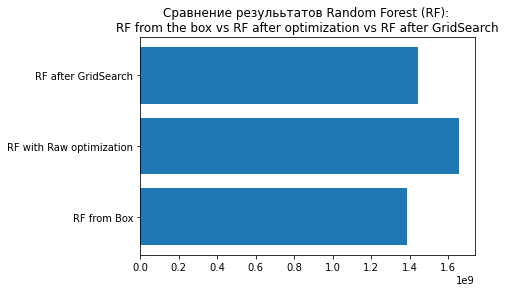

In [261]:
# Сравним результаты 'напильника':
plt.barh(y=[1,2,3] ,width=[score_random_forest , score_rf, score_rf_best ],tick_label=['RF from Box', 
                                                                             'RF with Raw optimization', 
                                                                             'RF after GridSearch'] )
plt.title('Сравнение резулььтатов Random Forest (RF): \nRF from the box vs RF after optimization vs RF after GridSearch')

#### Вывод: Random Forest из коробки работает лучше, чем  Random Forest с оптимизацией.

In [262]:
# Результаты с raw optimization не очень порадовали. Вывод: нужно подбирать каждый параметр отдельно.
# буду использовать результат из коробки
# выведем важность признаков
random_forest_features = pd.Series(data=rf_reg.feature_importances_, index=X_train.columns)
random_forest_features.sort_values(ascending=False).head()

GarageCars_3    0.305770
GrLivArea       0.198379
ExterQual_TA    0.116116
TotalBsmtSF     0.047990
1stFlrSF        0.041186
dtype: float64

#### AdaBoost

In [241]:
from sklearn.model_selection import GridSearchCV

In [248]:
params = {'base_estimator':[DecisionTreeRegressor(max_depth =5),DecisionTreeRegressor(max_depth=10),DecisionTreeRegressor(max_depth=15)]}
adagrid = GridSearchCV(AdaBoostRegressor() , params,cv=10,
             scoring='neg_mean_squared_error', n_jobs=-1 )
adagrid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=5),
                                            DecisionTreeRegressor(max_depth=10),
                                            DecisionTreeRegressor(max_depth=15)]},
             scoring='neg_mean_squared_error')

In [249]:
adagrid.best_params_

{'base_estimator': DecisionTreeRegressor(max_depth=10)}

In [255]:
adaboost_reg_best = adagrid.best_estimator_

y_pred_adaBoost_best = adaboost_reg_best.predict(X_test)
score_adaBoost_best = mean_squared_error(y_test, y_pred_adaBoost_best)
score_adaBoost_best

1090998058.88348

In [256]:
# Собеерем Регрессор
adaboost_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5) , n_estimators=500, learning_rate=1)

# Обучим
adaboost_reg.fit(X_train, y_train)

y_pred_adaBoost = adaboost_reg.predict(X_test)
score_adaBoost = mean_squared_error(y_test, y_pred_adaBoost)

score_adaBoost

1268876151.3060186

### ДЗ.№4 Stacking
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

#### Final Regressor - Linear Regressor

In [225]:
# соберем стекинг из самых лучших моделей:
stack_reg = StackingRegressor(  estimators = [

    ( 'dt5', DecisionTreeRegressor(max_depth=5) ),
    ( 'rf', RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, n_jobs=-1 ) ),
    ( 'adaBoost', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5) , n_estimators=10, learning_rate=1) ),
    ( 'LightGBM', lgb.LGBMRegressor(boosting_type='gbdt',num_leaves = 4,max_depth = 9,learning_rate= 0.0067,n_estimators = 78,
                                   min_split_gain=0.005,min_child_samples=17, reg_alpha= 0.171, reg_lambda= .833, subsample_freq=2,
                                   colsample_bytree=0.512) )
    
    ],final_estimator= LinearRegression() , cv=10, n_jobs=-1 )

In [226]:
stack_reg.fit(X_train,y_train)
y_pred_stacking = stack_reg.predict(X_test)
mean_squared_error(y_test, y_pred_stacking)

1775190697.002395

<BarContainer object of 4 artists>

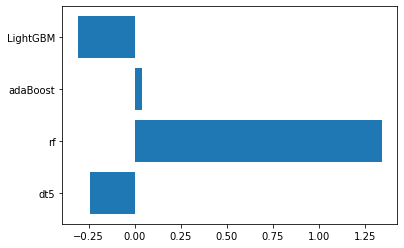

In [227]:
# Сравним результаты :
plt.barh(y=range(4) ,width=stack_reg.final_estimator_.coef_,tick_label=list(stack_reg.named_estimators_.keys()) )

#### Final Regressor -Tree

In [229]:
# соберем стекинг из самых лучших моделей:
stack_reg = StackingRegressor(  estimators = [

    ( 'dt5', DecisionTreeRegressor(max_depth=5) ),
    ( 'rf', RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, n_jobs=-1 ) ),
    ( 'adaBoost', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5) , n_estimators=10, learning_rate=1) ),
    ( 'LightGBM', lgb.LGBMRegressor(boosting_type='gbdt',num_leaves = 4,max_depth = 9,learning_rate= 0.0067,n_estimators = 78,
                                   min_split_gain=0.005,min_child_samples=17, reg_alpha= 0.171, reg_lambda= .833, subsample_freq=2,
                                   colsample_bytree=0.512) )
    
    ],final_estimator= DecisionTreeRegressor(max_depth=5) , cv=10, n_jobs=-1 )

In [230]:
stack_reg.fit(X_train,y_train)
y_pred_stacking = stack_reg.predict(X_test)
mean_squared_error(y_test, y_pred_stacking)

1687247877.560188

<BarContainer object of 4 artists>

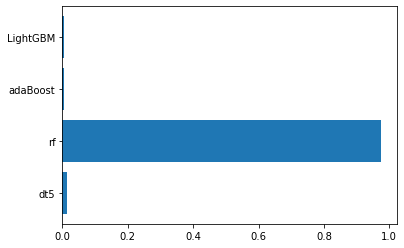

In [231]:
# Сравним результаты :
plt.barh(y=range(4) ,width=stack_reg.final_estimator_.feature_importances_,tick_label=list(stack_reg.named_estimators_.keys()) )


### Выводы:

Был выполнен расчет датасета www.kaggle.com...iques/data (train.csv) и (test.csv)
Был повторен алгоритм DBScan в написанной функции 'get_DBscan'

Так как датасеты (c предыдущей работы HW_7) совпадают, то результаты объединю для наглядности:

1. Из Предыдущей работы HW_7:
- Случайный лес (написанный handmade)
- Случайный лес из коробки 
- Стекинг с несколкими лесами и линейной регрессией (написанный handmade)
- Стекинг с несколкими лесами и линейной регрессией из коробки
- Gradient Boost (написанный handmade)
- XGBoost 
- Adaboost

2. Из текущей работы HW_8:
- Stacking with best models (Final Regressor -Tree)
- Stacking with best models (Final Regressor -Linear Regressor)
- AdaBoost gridSearch
- Random Forest with params optimization
- Light Gradient Boosting (LightGB)
- LightGB with params optimization 
- LightGB with params optimization with 5 K-fold


Все датасеты уже были разбиты на треин и тест, внутри трейна создавалась валидационная выборка, по ней проводилась оценка обучения.  
Финальные результаты рассчитывались на тест выборке.  

Были получены следующие результаты по метрике Mean_Squared_Error:

In [268]:
pd.options.display.float_format = '{:16.0f}'.format

In [271]:
results = pd.DataFrame()
results['Random Forest handmade(функция, которую написал сам) '] = [938012653]
results['Random Forest sklearn'] = [1388006206.33]
results['Random Forest with raw params optimization'] = [1656783586.47]
results['Random Forest gridSearch'] = [1441984208.21]


results['Gradient Boost handmade '] = [2170491596.571897]
results['XGBoost '] = [3038480889.652186]

results['Adaboost '] = [1187523029.1579857]
results['AdaBoost gridSearch'] = [1090998058.88348]

results['LightGB'] = [1656783586.47]
results['LightGB with params optimization'] = [206787227.62]
results['LightGB with params optimization with 5 K-fold'] = [201377359.74]

results['Stacking with best models (Final Regressor - Tree)'] = [1687247877.56]
results['Stacking with best models (Final Regressor - Linear)'] = [1775190697]

results.index = ['MSE']
results = results.T
results['root_MSE'] = results.MSE.apply(lambda x: x**0.5)
results.sort_values(['root_MSE'],ascending=True,inplace=True)
results

,MSE,root_MSE
LightGB with params optimization with 5 K-fold,201377360,14191
LightGB with params optimization,206787228,14380
"Random Forest handmade(функция, которую написал сам)",938012653,30627
AdaBoost gridSearch,1090998059,33030
Adaboost,1187523029,34460
Random Forest sklearn,1388006206,37256
Random Forest gridSearch,1441984208,37973
Random Forest with raw params optimization,1656783586,40704
LightGB,1656783586,40704
Stacking with best models (Final Regressor - Tree),1687247878,41076


### Выводы: 
- Лучшей моделью оказалась "LightGB with params optimization with 5 K-fold" 
- Лучшим методом построения ансамбля (с отрывом от следующего в два раза) - "Light Gradient Boosting"
- Второй по результативности метод построения ансамбля - Random Forest
- Третий по результативности метод построения ансамбля - Adaboost
- Методы 'Random Forest' и 'Adaboost' лучше всего работают из коробки, а метод 'Light Gradient Boosting' улучшил свой результат в 3 раза после оптимизации